# Inter-comparison and validation against in-situ measurements of satellite estimates of incoming solar radiation for Indien Ocean at BSRN site (RE)

**Auteur :**  GRONDIN Erwan

**Date :**  05/06/2024

---

# Les nouvelles commandes apprises

+ mettre une texte en gras : `fontweight='bold'`
+ avoir accès aux données geographiques d'une stations : `data_geo.loc['urmoufia']`



---

In [1]:
# library
import glob
import os
import seaborn as sns
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pvlib
from pvlib.location import Location
from pandas.plotting import register_matplotlib_converters
import plotly.graph_objects as go
import xarray as xr
import netCDF4 as nc
import sys
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime
import plotly.express as px
from plotly.subplots import make_subplots

from scipy.signal import savgol_filter
from sklearn.cluster import KMeans as KM
import warnings

#############################################################################################################
# Désactiver l'affichage des FutureWarnings temporairement
warnings.simplefilter(action='ignore', category=FutureWarning)
#############################################################################################################

#############################################################################################################
#sns.set(style="darkgrid", palette="bright",context = "paper",font="Arial" )
sns.set(style="darkgrid", palette="bright",context = "talk",font="Arial" )
#############################################################################################################

#############################################################################################################
def hourly_mean(df):
    data = df.copy()
    data.index = pd.to_datetime(data.index)
    
    # Filtrer les heures UTC entre 02h et 14h (inclus)
    df_filtered = data.between_time('02:00', '14:00')
    # Group data by hour and calculate the mean
    df_hourly_mean = df_filtered.resample('H').mean()
    return df_hourly_mean
#############################################################################################################
def daily_mean(df):
    data = df.copy()
    data.index = pd.to_datetime(data.index)
    
    # Filtrer les heures entre 01h et 15h (inclus)
    df_filtered = data.between_time('02:00', '14:00')
    # Group data by hour and calculate the mean
    df_daily_mean = df_filtered.resample('D').mean()
    return df_daily_mean


#############################################################################################################
def monthly_mean(df):
    data = df.copy()
    data.index = pd.to_datetime(data.index)
    # Group data by hour and calculate the mean
    df_mounthly_mean = data.resample('M').mean()
    return df_mounthly_mean


#############################################################################################################
def yearly_mean(df):
    data = df.copy()
    data.index = pd.to_datetime(data.index)
    # Group data by hour and calculate the mean
    df_yearly_mean = data.resample('Y').mean()
    return df_yearly_mean


#############################################################################################################
def count_nan(df):
    """
    Count the number of np.nan values in a DataFrame.

    Args :
        df (DataFrame) : pandas DataFrame

    Returns :
        count (Integer) : Number of np.nan values
    """
    # Count the number of np.nan in the DataFrame
    count = df.isnull().sum().sum()
    
    return count

#############################################################################################################
def Savitzky_Golay_filter(data, variable, WL ,PO):
    '''
    Input :
        data (dataframe) : datframe contains irradiance data
        variable (str) : name of column who you would like to smooth
    Return:
        df (dataframe) : dataframe filter with Savitzky-Golay
    '''
    
    df_1 = data.copy()
    df_2 = pd.DataFrame(df_1[variable])
    int_nan_value = count_nan(df_2) # nombre de valeur manquante avant la selection entre 02H et 14H
    print("Le nombre de valeurs NaN avant la sélection :",int_nan_value)
    df_2.index = pd.to_datetime(df_2.index)
    df_filtered = df_2.between_time('02:00', '14:00')

    df_cleaned = df_filtered.dropna(how='all')
    
    final_nan_value = count_nan(df_filtered) # nombre de valeur manquante après la selection entre 02H et 14H
    print("Le nombre de valeurs NaN après la sélection :",final_nan_value)


    smoothed_data = savgol_filter(df_cleaned[variable], WL, PO)
    df_cleaned_cop = df_cleaned.copy()
    df_cleaned_cop[f'{variable}_smoothed'] = smoothed_data
    df = df_cleaned_cop.clip(lower=0)
    df.index = pd.to_datetime(df.index)

    return df

#############################################################################################################
def formalisation_data(data_filter):
    mydf = data_filter.copy()
    # Supprimer le nom de l'index de la copie
    mydf.index.name = None
    mydf.index = pd.to_datetime(mydf.index)
    mydf = mydf.reset_index()
    mydf = mydf.rename(columns={'index': 'timestamp'})
    #mydf = mydf.rename(columns={variable: 'SIS_filtred'})
    mydf['date'] = mydf['timestamp'].dt.strftime('%Y/%m/%d')
    mydf['date'] = pd.to_datetime(mydf['date'], format='%Y/%m/%d')
    mydf['heure'] = mydf['timestamp'].dt.strftime('%H:%M:%S')
    mydf['ID'] =  ['D{}'.format(i + 1) for i in mydf.index]
    # Trouver la première date
    first_date = mydf['date'].min()
    # Calculer le nombre de jours écoulés depuis la première date
    mydf['ID_date'] = (mydf['date'] - first_date).dt.days + 1
    mydf2 = mydf.pivot_table(values='ghi',index='heure',columns='ID_date')
    return round(mydf2,3)

#############################################################################################################
def scaled_data(data_filter,variable):
    mydf = data_filter.copy()
    mydf.index = pd.to_datetime(mydf.index)
    mydf = mydf.reset_index()
    mydf = mydf.rename(columns={'index': 'timestamp'})
    #mydf = mydf.rename(columns={variable: 'SIS_filtred'})
    mydf['date'] = mydf['timestamp'].dt.strftime('%Y/%m/%d')
    mydf['date'] = pd.to_datetime(mydf['date'], format='%Y/%m/%d')
    mydf['heure'] = mydf['timestamp'].dt.strftime('%H:%M:%S')
    mydf['ID'] =  ['D{}'.format(i + 1) for i in mydf.index]
    # Trouver la première date
    first_date = mydf['date'].min()
    # Calculer le nombre de jours écoulés depuis la première date
    mydf['ID_date'] = (mydf['date'] - first_date).dt.days + 1
    mydf2 = mydf.pivot_table(values=variable,index='heure',columns='ID_date')
    scaled_mydf2 = (mydf2 - mydf2.mean(axis = 0))
    scaled_mydf2_without_NaN = scaled_mydf2.dropna(axis=1, how='any')
    return scaled_mydf2 , scaled_mydf2_without_NaN

# Useful data

In [2]:
#######################################  Geographical data ######################################################################
data_geo = pd.read_csv('data_geo_adaptation.csv', sep=';', index_col=0)

#######################################  SARAH ######################################################################
df_sarah_DNI = pd.read_csv('data_urmoufia/data_UTC/SARAH_3_DNI_moufia.csv', sep=';', index_col=0)
df_sarah_GHI = pd.read_csv('data_urmoufia/data_UTC/SARAH_3_SIS_moufia.csv', sep=';', index_col=0)

#######################################  IN-SITU ######################################################################
df_urmoufia = pd.read_csv('data_urmoufia/data_UTC/urmoufia.csv', sep=';', index_col=0)
df_BSRN = pd.read_csv('data_urmoufia/data_UTC/BSRN_data_2016_08_01_to_2024_04_01.csv', sep=';', index_col=0)

In [3]:
df_urmoufia.head()

,ghi,dhi,dni_ground,SZA,extra_radiation,mu0,dni,physical_limit_ghi,physical_limit_dhi,physical_limit_dni
2008-12-01 00:00:00,NaN,NaN,NaN,108.900321,1406.452485,0.1,NaN,233.111729,134.304095,1406.452485
2008-12-01 00:01:00,NaN,NaN,NaN,108.705327,1406.452485,0.1,NaN,233.111729,134.304095,1406.452485
2008-12-01 00:02:00,NaN,NaN,NaN,108.510036,1406.452485,0.1,NaN,233.111729,134.304095,1406.452485
2008-12-01 00:03:00,NaN,NaN,NaN,108.314451,1406.452485,0.1,NaN,233.111729,134.304095,1406.452485
2008-12-01 00:04:00,NaN,NaN,NaN,108.118574,1406.452485,0.1,NaN,233.111729,134.304095,1406.452485


# Utilisation du même pas de temps que CM-SAF

In [97]:
#############################################################################################################
def instantaneous_ios_data(df):
    data = df.copy() #copy dataframe
    data.index = pd.to_datetime(data.index) #convert index of dataframe to datetime 
    df_30min = data.resample('30T').first() #select data every 30 minutes
    #Filtrer les heures UTC entre 02h et 14h (inclus)
    df_filtered = df_30min.between_time('02:00', '14:00')
    return round(df_filtered,3) #round data with 3 digits
#############################################################################################################

In [98]:
df_urmoufia_30min = instantaneous_ios_data(df_urmoufia)
df_urmoufia_30min.head()

,ghi,dhi,dni_ground,SZA,extra_radiation,mu0,dni,physical_limit_ghi,physical_limit_dhi,physical_limit_dni
2008-12-01 02:00:00,NaN,NaN,NaN,83.923,1406.452,0.106,NaN,242.542,140.277,1406.452
2008-12-01 02:30:00,NaN,NaN,NaN,77.337,1406.452,0.219,NaN,441.408,266.225,1406.452
2008-12-01 03:00:00,NaN,NaN,NaN,70.665,1406.452,0.331,NaN,659.948,404.633,1406.452
2008-12-01 03:30:00,NaN,NaN,NaN,63.924,1406.452,0.440,NaN,886.747,548.273,1406.452
2008-12-01 04:00:00,NaN,NaN,NaN,57.127,1406.452,0.543,NaN,1113.355,691.792,1406.452


# Vérification de la qualité des données

In [99]:
df_urmoufia_30min_without_nan = df_urmoufia_30min[['ghi', 'SZA','physical_limit_ghi']].dropna(subset=['ghi', 'SZA','physical_limit_ghi'])
print('Nombre de valeurs manquantes : ', count_nan(df_urmoufia_30min_without_nan))
df_urmoufia_30min_without_nan.head()

Nombre de valeurs manquantes :  0


,ghi,SZA,physical_limit_ghi
2008-12-20 04:30:00,660.8,51.980,1284.645
2008-12-20 05:00:00,718.0,45.165,1493.223
2008-12-20 05:30:00,824.0,38.319,1683.797
2008-12-20 06:00:00,906.0,31.452,1851.173
2008-12-20 06:30:00,983.0,24.574,1990.878


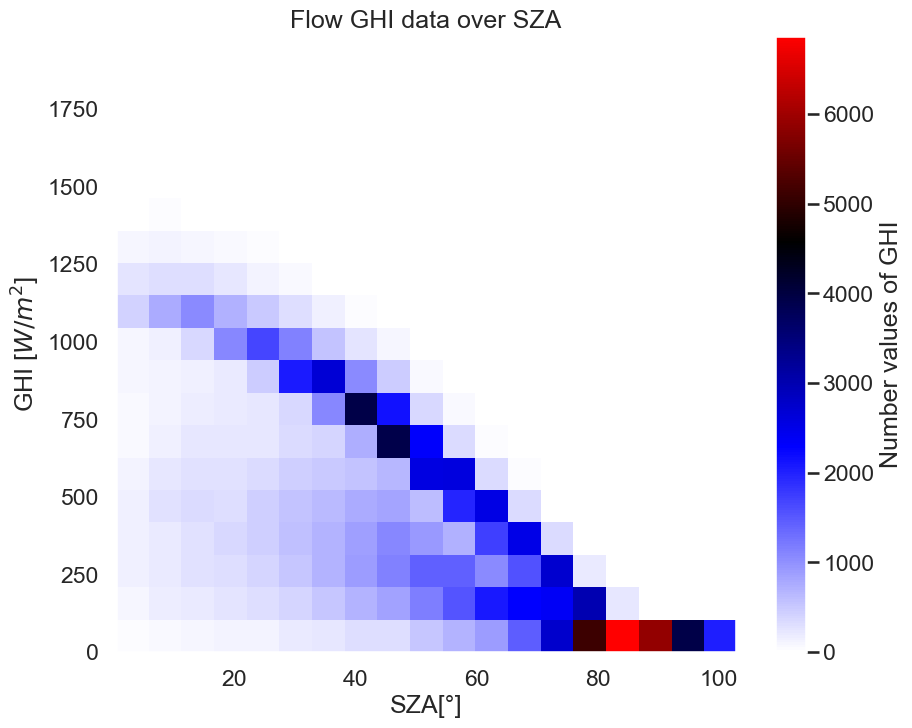

In [93]:
SZA = df_urmoufia_30min_without_nan['SZA'].values # Exemple de données SZA
GHI = df_urmoufia_30min_without_nan['ghi'].values  # Exemple de données GHI
GHI_limits = df_urmoufia_30min_without_nan['physical_limit_ghi'].values  

from matplotlib.colors import LinearSegmentedColormap
# Créer une colormap personnalisée allant de blanc à rouge
colors = [(1, 1, 1),  (0, 0, 1), (0,0,0) , (1, 0, 0)]  # Blanc à rouge
cmap_name = 'custom_red'
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors)

# Définir les bins pour la heatmap
sza_bins = np.linspace(df_urmoufia_30min_without_nan['SZA'].min(), df_urmoufia_30min_without_nan['SZA'].max(), 20)  # Vous pouvez ajuster le nombre de bins selon vos besoins
ghi_bins = np.linspace(df_urmoufia_30min_without_nan['ghi'].min(), df_urmoufia_30min_without_nan['ghi'].max(), 20)  # Vous pouvez ajuster le nombre de bins selon vos besoins

# Calculer l'histogramme 2D
heatmap, xedges, yedges = np.histogram2d(SZA, GHI, bins=[sza_bins, ghi_bins])

# Tracer la heatmap
plt.figure(figsize=(10, 8))
plt.imshow(heatmap.T, origin='lower', aspect='auto', 
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], 
           cmap=custom_cmap)


plt.grid(False)
plt.colorbar(label='Number values of GHI')
plt.xlabel('SZA[°]')
plt.ylabel('GHI [$W/m^2$]')
plt.title('Flow GHI data over SZA')
plt.show()

# Creat clear sky model

In [6]:
import pandas as pd
from pvlib import location
from pvlib.bifacial.pvfactors import pvfactors_timeseries
import matplotlib.pyplot as plt
import warnings

# supressing shapely warnings that occur on import of pvfactors
warnings.filterwarnings(action='ignore', module='pvfactors')


In [10]:
#times = pd.date_range('2021-06-21', '2021-06-22', freq='30T', tz='Indian/Reunion')
times = df_urmoufia_30min.index.tz_localize('UTC')
loc = location.Location(latitude=-20.925, longitude=55.475, tz=times.tz)
sp = loc.get_solarposition(times,temperature=25) #with 25°C same mean température à La Réunion
cs = loc.get_clearsky(times,model='haurwitz',solar_position=sp) # model 'haurwitz' -> ghi ; 'ineichen' -> ghi,dhi,dni

In [11]:
sp

,apparent_zenith,zenith,apparent_elevation,elevation,azimuth,equation_of_time
2008-12-01 02:00:00+00:00,83.789810,83.921739,6.210190,6.078261,111.085828,10.986005
2008-12-01 02:30:00+00:00,77.267936,77.336758,12.732064,12.663242,108.802469,10.978168
2008-12-01 03:00:00+00:00,70.621025,70.666122,19.378975,19.333878,106.738101,10.970326
2008-12-01 03:30:00+00:00,63.893444,63.926065,26.106556,26.073935,104.859018,10.962480
2008-12-01 04:00:00+00:00,57.104800,57.129606,32.895200,32.870394,103.140058,10.954629
...,...,...,...,...,...,...
2023-10-13 12:00:00+00:00,58.218138,58.244022,31.781862,31.755978,273.800754,13.711563
2023-10-13 12:30:00+00:00,65.206863,65.241433,24.793137,24.758567,270.953634,13.716582
2023-10-13 13:00:00+00:00,72.195436,72.244680,17.804564,17.755320,268.281576,13.721597
2023-10-13 13:30:00+00:00,79.158092,79.238339,10.841908,10.761661,265.685441,13.726609


In [12]:
cs

,ghi
2008-12-01 02:00:00+00:00,68.844116
2008-12-01 02:30:00+00:00,185.155101
2008-12-01 03:00:00+00:00,304.983596
2008-12-01 03:30:00+00:00,422.539198
2008-12-01 04:00:00+00:00,534.941063
...,...
2023-10-13 12:00:00+00:00,517.016716
2023-10-13 12:30:00+00:00,400.007858
2023-10-13 13:00:00+00:00,276.821398
2023-10-13 13:30:00+00:00,150.927466


In [68]:
cs = loc.get_clearsky(times,model='ineichen',solar_position=sp) 
cs

TypeError: pvlib.clearsky.ineichen() got multiple values for keyword argument 'altitude'

<Axes: >

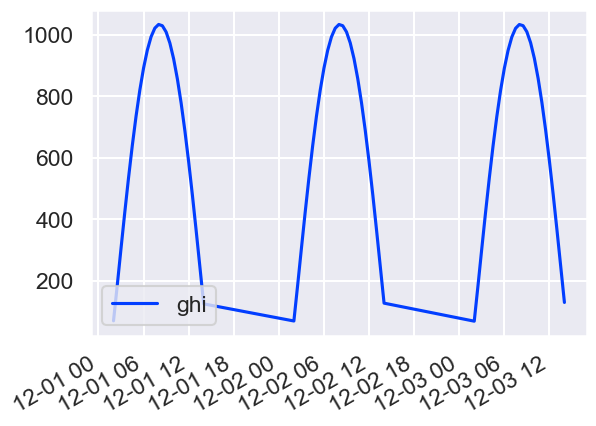

In [13]:
cs['2008-12-01':'2008-12-03'].plot()

In [7]:
#############################################################################################################
def formalisation_data(data_filter,var):
    mydf = data_filter.copy()
    # Supprimer le nom de l'index de la copie
    mydf.index.name = None
    mydf.index = pd.to_datetime(mydf.index)
    mydf = mydf.reset_index()
    mydf = mydf.rename(columns={'index': 'timestamp'})
    #mydf = mydf.rename(columns={variable: 'SIS_filtred'})
    mydf['date'] = mydf['timestamp'].dt.strftime('%Y/%m/%d')
    mydf['date'] = pd.to_datetime(mydf['date'], format='%Y/%m/%d')
    mydf['heure'] = mydf['timestamp'].dt.strftime('%H:%M:%S')
    mydf['ID'] =  ['D{}'.format(i + 1) for i in mydf.index]
    # Trouver la première date
    first_date = mydf['date'].min()
    # Calculer le nombre de jours écoulés depuis la première date
    mydf['ID_date'] = (mydf['date'] - first_date).dt.days + 1
    mydf2 = mydf.pivot_table(values=var,index='heure',columns='ID_date')
    return round(mydf2,3)

#############################################################################################################
df_summer = cs[cs.index.month.isin([11, 12, 1, 2,3,4])]
df_winter = cs[cs.index.month.isin([5, 6, 7, 8,9,10])]

formalis_summer_data = formalisation_data(df_summer,'ghi')
formalis_winter_data = formalisation_data(df_winter,'ghi')


NameError: name 'cs' is not defined

In [107]:
formalis_summer_data.head()

ID_date,1,2,3,4,5,6,7,8,9,10,...,5255,5256,5257,5258,5259,5260,5261,5262,5263,5264
heure,,,,,,,,,,,,,,,,,,,,,
02:00:00,32.048,31.712,31.326,30.893,30.413,29.889,29.322,28.714,28.067,27.383,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
02:30:00,128.757,128.149,127.469,126.720,125.903,125.019,124.070,123.058,121.984,120.850,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
03:00:00,245.277,244.517,243.683,242.777,241.801,240.757,239.646,238.470,237.231,235.930,...,34.224,33.294,32.364,31.435,30.508,29.582,28.660,27.740,26.825,25.915
03:30:00,365.413,364.559,363.635,362.643,361.585,360.462,359.276,358.029,356.723,355.359,...,138.488,137.026,135.552,134.067,132.572,131.066,129.551,128.027,126.496,124.956
04:00:00,482.778,481.875,480.908,479.878,478.788,477.638,476.432,475.171,473.856,472.489,...,257.291,255.548,253.790,252.017,250.230,248.431,246.619,244.797,242.964,241.121


In [16]:
formalis_winter_data.head()

ID_date,1,2,3,4,5,6,7,8,9,10,...,5270,5271,5272,5273,5274,5275,5276,5277,5278,5279
heure,,,,,,,,,,,,,,,,,,,,,
02:00:00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.015,0.109,0.369,0.853,1.583,2.556,3.752,5.147,6.715
02:30:00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,82.094,85.654,89.194,92.711,96.199,99.657,103.080,106.466,109.811,113.113
03:00:00,46.472,45.022,43.574,42.128,40.687,39.250,37.819,36.395,34.978,33.570,...,206.897,210.627,214.314,217.956,221.551,225.096,228.590,232.029,235.413,238.738
03:30:00,160.640,158.765,156.883,154.996,153.105,151.208,149.309,147.406,145.501,143.594,...,332.239,335.909,339.530,343.098,346.612,350.070,353.470,356.809,360.087,363.302
04:00:00,276.844,274.730,272.609,270.484,268.354,266.220,264.083,261.944,259.805,257.665,...,452.676,456.231,459.730,463.173,466.556,469.880,473.141,476.339,479.471,482.537


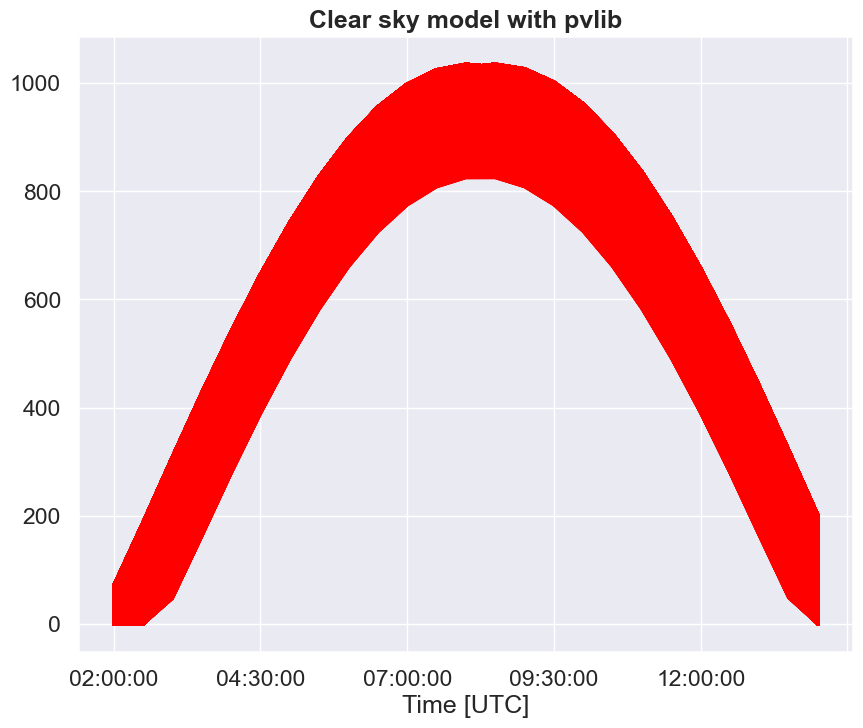

In [17]:
# Optimisation avec un seul appel de la fonction plot
plt.figure(figsize=(10, 8))

# Tracer toutes les colonnes d'un coup
formalis_summer_data.plot(ax=plt.gca(), color='red', legend=False)

# Ajuster l'espacement de la grille
plt.grid(True, which='both', linewidth=1)

plt.title("Clear sky model with pvlib",fontweight='bold')
plt.xlabel('Time [UTC]')
plt.show()

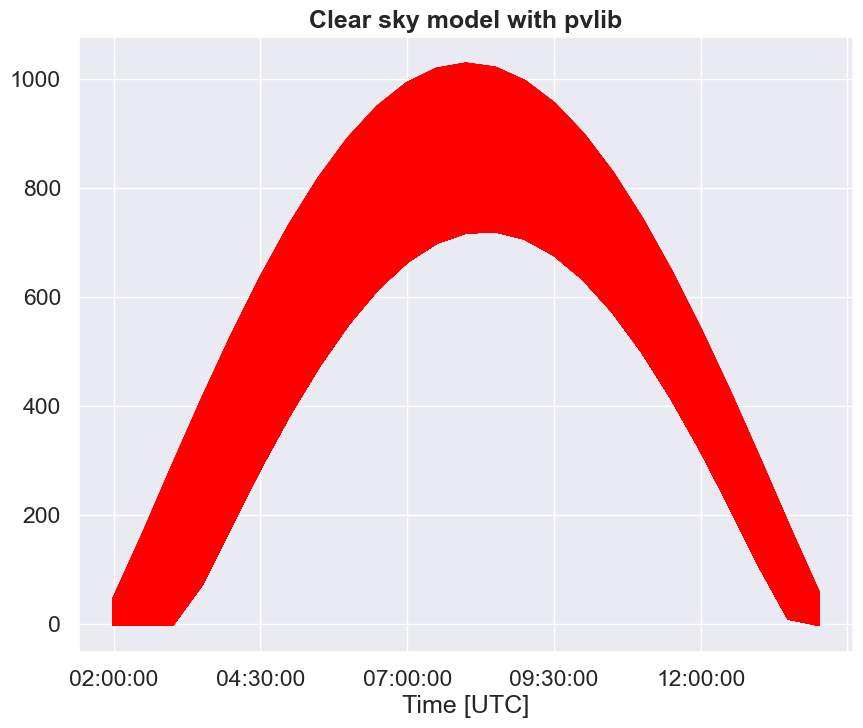

In [18]:
# Optimisation avec un seul appel de la fonction plot
plt.figure(figsize=(10, 8))

# Tracer toutes les colonnes d'un coup
formalis_winter_data.plot(ax=plt.gca(), color='red', legend=False)

# Ajuster l'espacement de la grille
plt.grid(True, which='both', linewidth=1)

plt.title("Clear sky model with pvlib",fontweight='bold')
plt.xlabel('Time [UTC]')
plt.show()

# Found the trend curve

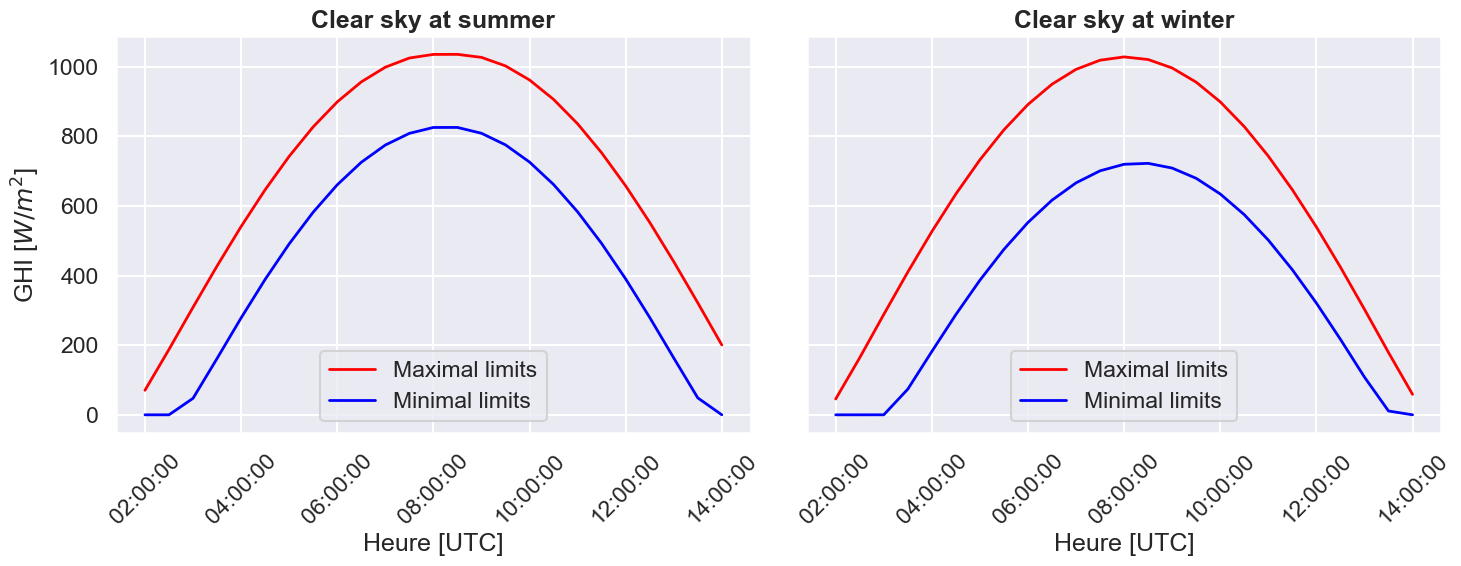

In [19]:
#----- summer
trend_max_summer = formalis_summer_data.max(axis=1).tolist()
trend_min_summer = formalis_summer_data.min(axis=1).tolist()
#----- winter
trend_max_winter = formalis_winter_data.max(axis=1).tolist()
trend_min_winter = formalis_winter_data.min(axis=1).tolist()


fig, axes = plt.subplots(1, 2, figsize=(15, 6),sharey=True)

# Tracer les données sur chaque sous-graphe
axes[0].plot(formalis_summer_data.index, trend_max_summer,lw = 2,color='red',label ='Maximal limits')
axes[0].plot(formalis_summer_data.index, trend_min_summer,lw = 2,color='blue',label ='Minimal limits')
axes[0].set_title('Clear sky at summer',  fontweight='bold')
axes[0].set_xlabel('Heure [UTC]')
axes[0].set_ylabel('GHI [$W/m^2$]')
axes[0].legend()

# Tracer les données sur chaque sous-graphe
axes[1].plot(formalis_summer_data.index, trend_max_winter,lw = 2,color='red',label ='Maximal limits')
axes[1].plot(formalis_summer_data.index, trend_min_winter,lw = 2,color='blue',label ='Minimal limits')
axes[1].set_title('Clear sky at winter',  fontweight='bold')
axes[1].set_xlabel('Heure [UTC]')
axes[1].legend()

# Pour chaque sous-graphique, ajustez les étiquettes de l'axe x
axes[0].set_xticks(formalis_summer_data.index[::4])  # Affiche une étiquette sur 4
axes[1].set_xticks(formalis_summer_data.index[::4])  # Affiche une étiquette sur 4

# Rotation des étiquettes pour éviter le chevauchement
axes[0].tick_params(axis='x', rotation=45)
axes[1].tick_params(axis='x', rotation=45)

plt.xticks(rotation=45)
# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()

# Afficher la figure
plt.show()


# Apply clear sky classification

In [20]:
df_urmoufia_summer = df_urmoufia_30min[df_urmoufia_30min.index.month.isin([11, 12, 1, 2, 3, 4])]
df_urmoufia_winter = df_urmoufia_30min[df_urmoufia_30min.index.month.isin([5, 6, 7, 8, 9, 10])]
df_urmoufia_summer

,ghi,dhi,dni_ground,SZA,extra_radiation,mu0,dni,physical_limit_ghi,physical_limit_dhi,physical_limit_dni
2008-12-01 02:00:00,NaN,NaN,NaN,83.923,1406.452,0.106,NaN,242.542,140.277,1406.452
2008-12-01 02:30:00,NaN,NaN,NaN,77.337,1406.452,0.219,NaN,441.408,266.225,1406.452
2008-12-01 03:00:00,NaN,NaN,NaN,70.665,1406.452,0.331,NaN,659.948,404.633,1406.452
2008-12-01 03:30:00,NaN,NaN,NaN,63.924,1406.452,0.440,NaN,886.747,548.273,1406.452
2008-12-01 04:00:00,NaN,NaN,NaN,57.127,1406.452,0.543,NaN,1113.355,691.792,1406.452
...,...,...,...,...,...,...,...,...,...,...
2023-04-30 12:00:00,45.420,46.550,NaN,65.679,1345.658,0.412,-2.744,796.171,490.909,1345.658
2023-04-30 12:30:00,10.360,9.830,NaN,71.968,1345.658,0.310,1.712,594.198,362.992,1345.658
2023-04-30 13:00:00,10.210,9.930,NaN,78.440,1345.658,0.200,1.397,393.287,235.748,1345.658
2023-04-30 13:30:00,3.004,2.396,NaN,85.051,1345.658,0.100,6.080,227.358,130.660,1345.658


Le nombre de valeurs NaN avant la sélection : 6528
Le nombre de valeurs NaN après la sélection : 6528
Index(['ghi', 'ghi_smoothed'], dtype='object')
Nombre de journée valide à lanalyse : 2373
Nombre de journée de ciel clair : 11


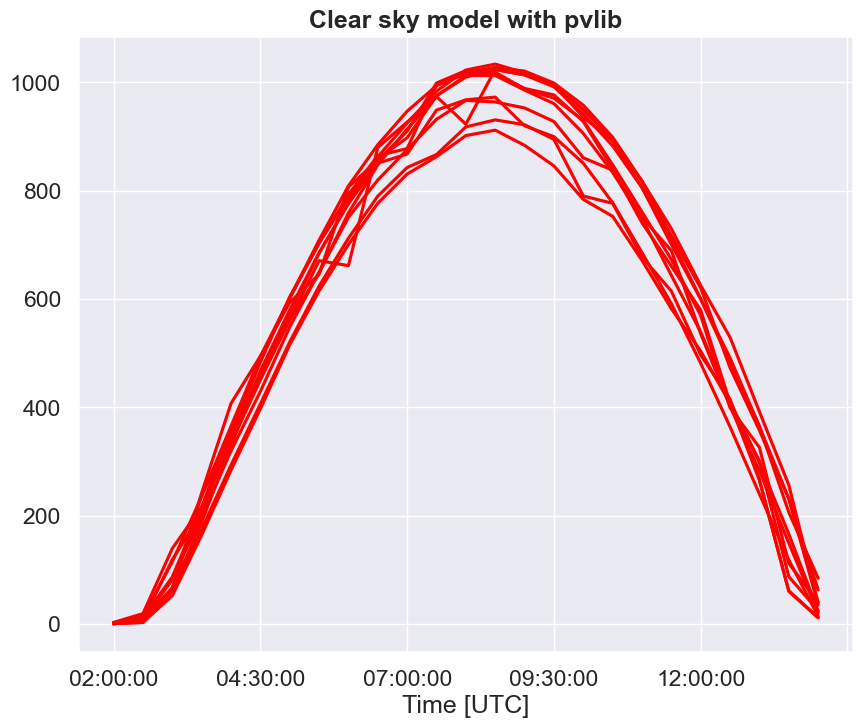

In [21]:
data , variable, trend_min,trend_max = df_urmoufia_summer, 'ghi',trend_min_summer,trend_max_summer

df = data.copy()
df_filter = Savitzky_Golay_filter(df, variable, 5 , 2)
print(df_filter.columns)
df_summer_form = formalisation_data(df_filter)
mydf = df_summer_form.dropna(axis=1, how='any')

nb_tot_day = mydf.shape[1]
print('Nombre de journée valide à l''analyse :',nb_tot_day)

selected_columns_sun_day = []
# Parcourir les colonnes de votre DataFrame
for col in mydf.columns:
    ghi_values = mydf[col].values
    # Vérifier si toutes les valeurs de ghi_values sont entre les tendances max et min
    if np.all((ghi_values >= trend_min) & (ghi_values <= trend_max)):
        selected_columns_sun_day.append(col)
df_sun_days = mydf.loc[:, selected_columns_sun_day]
nb_sun_day = len(selected_columns_sun_day)
print('Nombre de journée de ciel clair :',nb_sun_day)


# Optimisation avec un seul appel de la fonction plot
plt.figure(figsize=(10, 8))

# Tracer toutes les colonnes d'un coup
df_sun_days.plot(ax=plt.gca(), color='red', legend=False)

# Ajuster l'espacement de la grille
plt.grid(True, which='both', linewidth=1)

plt.title("Clear sky model with pvlib",fontweight='bold')
plt.xlabel('Time [UTC]')
plt.show()

Le nombre de valeurs NaN avant la sélection : 2430
Le nombre de valeurs NaN après la sélection : 2430
Index(['ghi', 'ghi_smoothed'], dtype='object')
Nombre de journée valide à lanalyse : 2594
Nombre de journée de ciel clair : 52


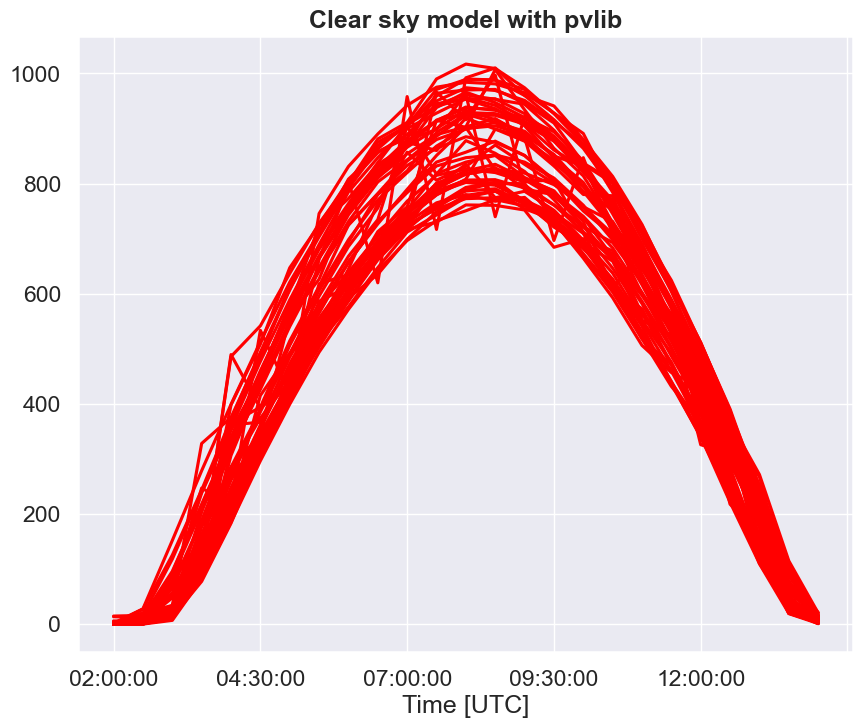

In [108]:
data , variable, trend_min,trend_max = df_urmoufia_winter, 'ghi',trend_min_winter,trend_max_winter

df = data.copy()
df_filter = Savitzky_Golay_filter(df, variable, 5 , 2)
print(df_filter.columns)
df_summer_form = formalisation_data(df_filter,'ghi')
mydf = df_summer_form.dropna(axis=1, how='any')

nb_tot_day = mydf.shape[1]
print('Nombre de journée valide à l''analyse :',nb_tot_day)

selected_columns_sun_day = []
# Parcourir les colonnes de votre DataFrame
for col in mydf.columns:
    ghi_values = mydf[col].values
    # Vérifier si toutes les valeurs de ghi_values sont entre les tendances max et min
    if np.all((ghi_values >= trend_min) & (ghi_values <= trend_max)):
        selected_columns_sun_day.append(col)
df_sun_days = mydf.loc[:, selected_columns_sun_day]
nb_sun_day = len(selected_columns_sun_day)
print('Nombre de journée de ciel clair :',nb_sun_day)


# Optimisation avec un seul appel de la fonction plot
plt.figure(figsize=(10, 8))

# Tracer toutes les colonnes d'un coup
df_sun_days.plot(ax=plt.gca(), color='red', legend=False)

# Ajuster l'espacement de la grille
plt.grid(True, which='both', linewidth=1)

plt.title("Clear sky model with pvlib",fontweight='bold')
plt.xlabel('Time [UTC]')
plt.show()

Le nombre de valeurs NaN avant la sélection : 2430
Le nombre de valeurs NaN après la sélection : 2430
Index(['ghi', 'ghi_smoothed'], dtype='object')
Nombre de journée valide à lanalyse : 2594
Nombre de journée de ciel clair : 153


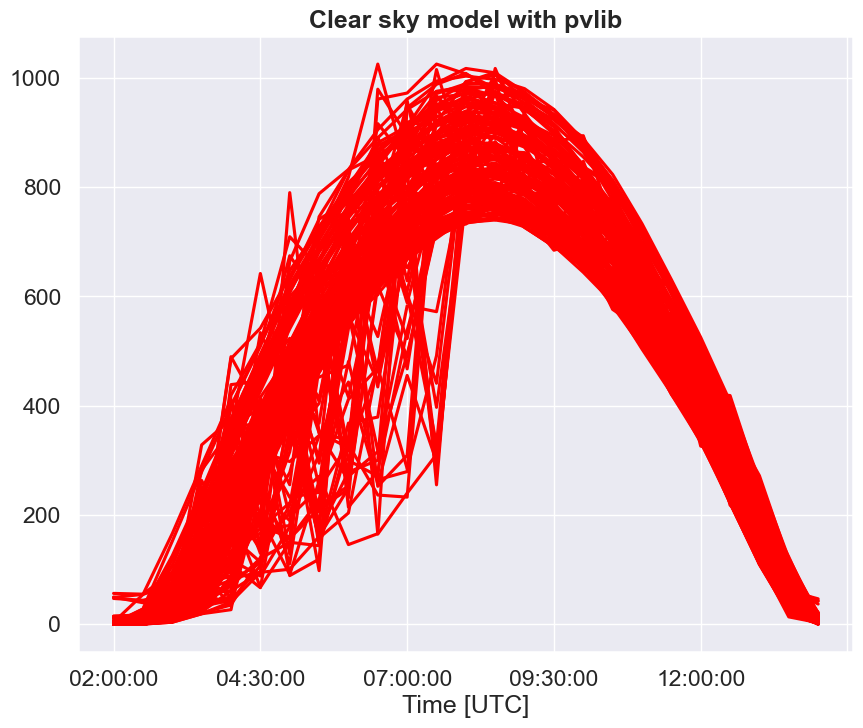

In [109]:
data , variable, trend_min,trend_max = df_urmoufia_winter, 'ghi',trend_min_winter,trend_max_winter

#--- clear PM ----------
df = data.copy()
df_filter = Savitzky_Golay_filter(df, variable, 5 , 2)
print(df_filter.columns)
df_summer_form = formalisation_data(df_filter,'ghi')
mydf = df_summer_form.dropna(axis=1, how='any')

nb_tot_day = mydf.shape[1]
print('Nombre de journée valide à l''analyse :',nb_tot_day)

selected_columns = []
# Parcourir les colonnes de votre DataFrame
for col in mydf.columns:
    ghi_values = mydf[col].values[12:]
    # Vérifier si toutes les valeurs de ghi_values sont entre les tendances max et min
    if np.all((ghi_values >= trend_min[12:]) & (ghi_values <= trend_max[12:])):
        selected_columns.append(col)
df_days = mydf.loc[:, selected_columns]
nb_day = len(selected_columns)
print('Nombre de journée de ciel clair :',nb_day)


# Optimisation avec un seul appel de la fonction plot
plt.figure(figsize=(10, 8))

# Tracer toutes les colonnes d'un coup
df_days.plot(ax=plt.gca(), color='red', legend=False)

# Ajuster l'espacement de la grille
plt.grid(True, which='both', linewidth=1)

plt.title("Clear sky model with pvlib",fontweight='bold')
plt.xlabel('Time [UTC]')
plt.show()

Le nombre de valeurs NaN avant la sélection : 2430
Le nombre de valeurs NaN après la sélection : 2430
Index(['ghi', 'ghi_smoothed'], dtype='object')
Nombre de journée valide à lanalyse : 2594
Nombre de journée de ciel clair : 320


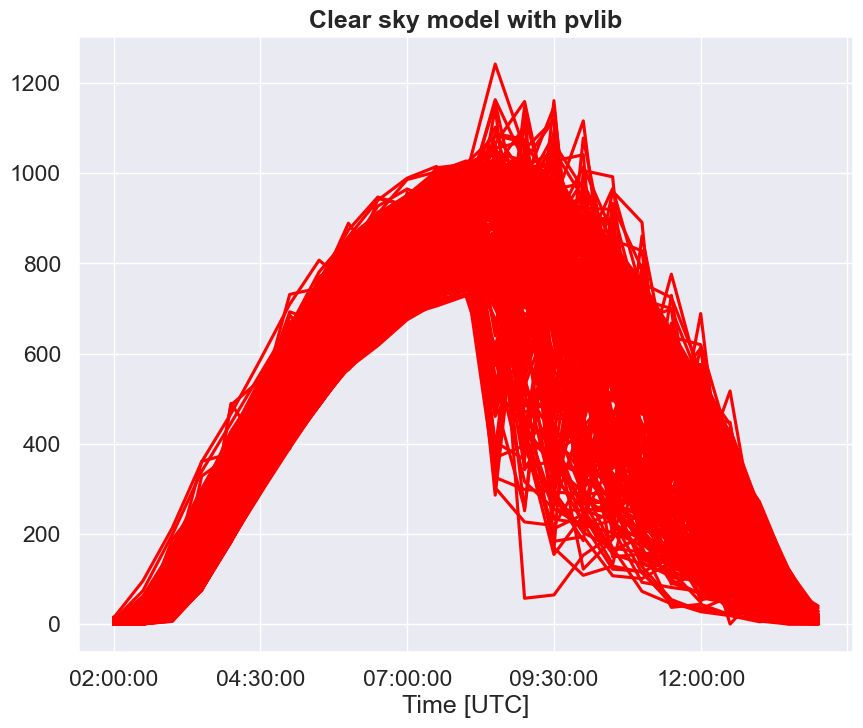

In [110]:
data , variable, trend_min,trend_max = df_urmoufia_winter, 'ghi',trend_min_winter,trend_max_winter

#--- clear PM ----------
df = data.copy()
df_filter = Savitzky_Golay_filter(df, variable, 5 , 2)
print(df_filter.columns)
df_summer_form = formalisation_data(df_filter,'ghi')
mydf = df_summer_form.dropna(axis=1, how='any')

nb_tot_day = mydf.shape[1]
print('Nombre de journée valide à l''analyse :',nb_tot_day)

selected_columns = []
# Parcourir les colonnes de votre DataFrame
for col in mydf.columns:
    ghi_values = mydf[col].values[:13]
    # Vérifier si toutes les valeurs de ghi_values sont entre les tendances max et min
    if np.all((ghi_values >= trend_min[:13]) & (ghi_values <= trend_max[:13])):
        selected_columns.append(col)
df_days = mydf.loc[:, selected_columns]
nb_day = len(selected_columns)
print('Nombre de journée de ciel clair :',nb_day)


# Optimisation avec un seul appel de la fonction plot
plt.figure(figsize=(10, 8))

# Tracer toutes les colonnes d'un coup
df_days.plot(ax=plt.gca(), color='red', legend=False)

# Ajuster l'espacement de la grille
plt.grid(True, which='both', linewidth=1)

plt.title("Clear sky model with pvlib",fontweight='bold')
plt.xlabel('Time [UTC]')
plt.show()

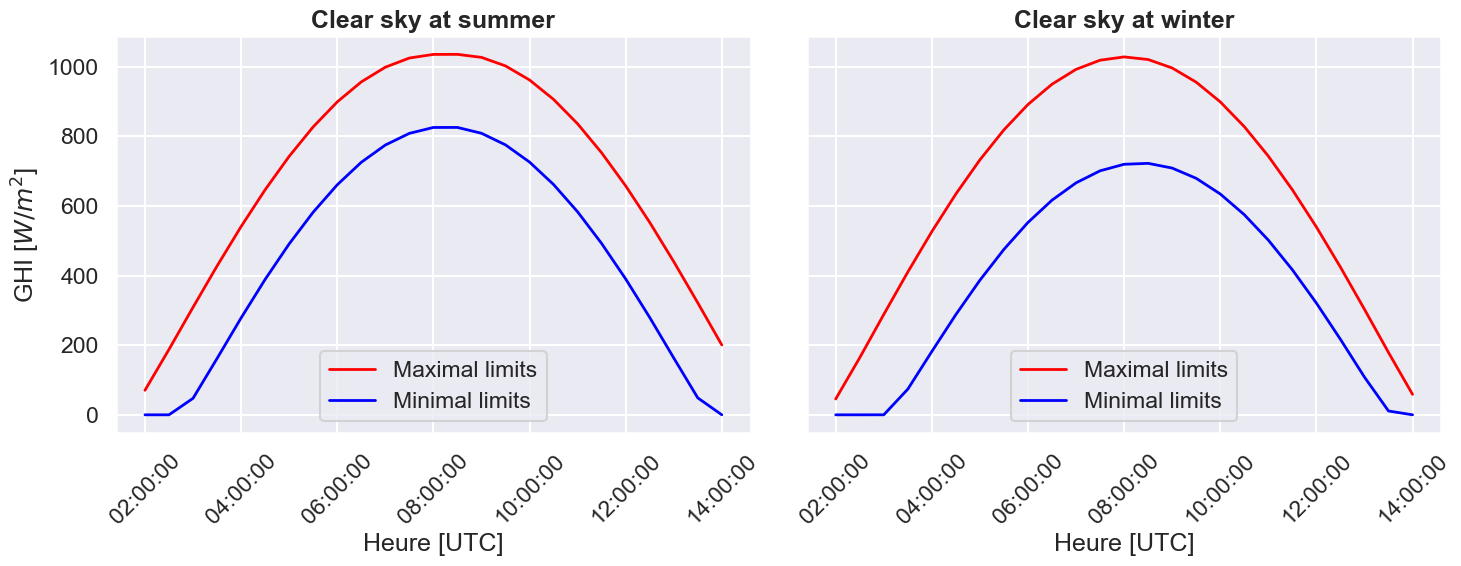

In [46]:
#----- summer
trend_max_summer_clear_sky = formalis_summer_data.max(axis=1).tolist()
trend_min_summer_clear_sky = formalis_summer_data.min(axis=1).tolist()
#----- winter
trend_max_winter_clear_sky = formalis_winter_data.max(axis=1).tolist()
trend_min_winter_clear_sky = formalis_winter_data.min(axis=1).tolist()


fig, axes = plt.subplots(1, 2, figsize=(15, 6),sharey=True)

# Tracer les données sur chaque sous-graphe
axes[0].plot(formalis_summer_data.index, trend_max_summer_clear_sky,lw = 2,color='red',label ='Maximal limits')
axes[0].plot(formalis_summer_data.index, trend_min_summer_clear_sky,lw = 2,color='blue',label ='Minimal limits')
axes[0].set_title('Clear sky at summer',  fontweight='bold')
axes[0].set_xlabel('Heure [UTC]')
axes[0].set_ylabel('GHI [$W/m^2$]')
axes[0].legend()

# Tracer les données sur chaque sous-graphe
axes[1].plot(formalis_summer_data.index, trend_max_winter_clear_sky,lw = 2,color='red',label ='Maximal limits')
axes[1].plot(formalis_summer_data.index, trend_min_winter_clear_sky,lw = 2,color='blue',label ='Minimal limits')
axes[1].set_title('Clear sky at winter',  fontweight='bold')
axes[1].set_xlabel('Heure [UTC]')
axes[1].legend()

# Pour chaque sous-graphique, ajustez les étiquettes de l'axe x
axes[0].set_xticks(formalis_summer_data.index[::4])  # Affiche une étiquette sur 4
axes[1].set_xticks(formalis_summer_data.index[::4])  # Affiche une étiquette sur 4

# Rotation des étiquettes pour éviter le chevauchement
axes[0].tick_params(axis='x', rotation=45)
axes[1].tick_params(axis='x', rotation=45)

plt.xticks(rotation=45)
# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()

# Afficher la figure
plt.show()


In [51]:
cs[['ghi']]

,ghi
2008-12-01 02:00:00+00:00,68.844116
2008-12-01 02:30:00+00:00,185.155101
2008-12-01 03:00:00+00:00,304.983596
2008-12-01 03:30:00+00:00,422.539198
2008-12-01 04:00:00+00:00,534.941063
...,...
2023-10-13 12:00:00+00:00,517.016716
2023-10-13 12:30:00+00:00,400.007858
2023-10-13 13:00:00+00:00,276.821398
2023-10-13 13:30:00+00:00,150.927466


In [66]:


# Example values
cloud_cover = 70  # 50% cloud cover
ghi_clear = cs['ghi']  # clear-sky GHI in W/m^2
offset = 10  # optional offset value

# Linear conversion function
def cloud_cover_to_ghi_linear(cloud_cover, ghi_clear, offset):
    return ghi_clear * (1 - cloud_cover / 100) + offset

# Apply the function to clear-sky GHI to get the overcast GHI
ghi_overcast = cloud_cover_to_ghi_linear(cloud_cover, ghi_clear, offset)
cs['ghi_overcast'] = ghi_overcast.tolist()
cs

,ghi,ghi_overcast
2008-12-01 02:00:00+00:00,68.844116,30.653235
2008-12-01 02:30:00+00:00,185.155101,65.546530
2008-12-01 03:00:00+00:00,304.983596,101.495079
2008-12-01 03:30:00+00:00,422.539198,136.761759
2008-12-01 04:00:00+00:00,534.941063,170.482319
...,...,...
2023-10-13 12:00:00+00:00,517.016716,165.105015
2023-10-13 12:30:00+00:00,400.007858,130.002357
2023-10-13 13:00:00+00:00,276.821398,93.046419
2023-10-13 13:30:00+00:00,150.927466,55.278240


<Axes: >

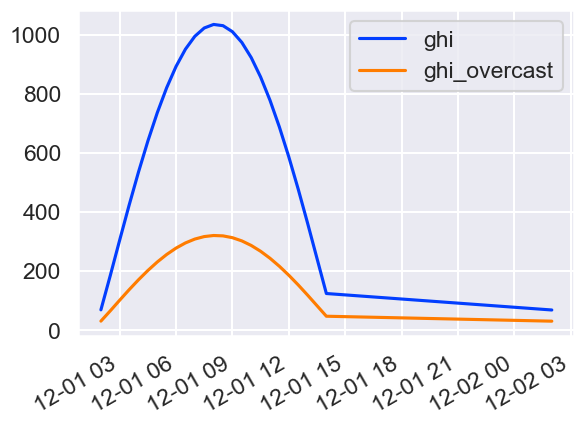

In [67]:
cs['2008-12-01 02:00:00+00:00':'2008-12-02 02:00:00+00:00'].plot()

In [19]:
data_geo

,Latitude,Longitude,Altitude,Latitude_modif,Longitude_modif
amitie,-4.321022,55.693360,3.00,-4.325,55.675
anseboileau,-4.710958,55.484734,2.00,-4.725,55.475
antananarivo,-18.898330,47.546420,1309.00,-18.875,47.525
aurere,-21.019772,55.424725,603.00,-21.025,55.425
braspanonmoreau,-21.002650,55.682896,20.00,-21.025,55.675
cavernedufour,-21.109177,55.495655,2495.00,-21.125,55.475
cilaosbrassec,-21.141754,55.489704,1269.00,-21.125,55.475
cilaospiscine,-21.136158,55.474160,1213.00,-21.125,55.475
cilaosthermes,-21.128940,55.473320,1255.80,-21.125,55.475
craterebory,-21.244139,55.709020,2584.20,-21.225,55.725


In [26]:
data_geo.loc['urmoufia']

Latitude          -20.901460
Longitude          55.483593
Altitude           96.000000
Latitude_modif    -20.925000
Longitude_modif    55.475000
Name: urmoufia, dtype: float64

# IOS-net classification

In [114]:
def selection_same_temporal_data(data_ios,data_sarah):
    """
    This function permit to select the same temporal resolution between two data

    Args :
        data_ios (DataFrame) : pandas DataFrame of IOS-net data
        data_sarah (DataFrame) : pandas DataFrame of SARAH-3 data

    Returns :
        new_ios_data : selective data of IOS-net data
        new_sarah_data : selective data of SARAH-3 data

    Example : 
        data_ios = pd.read_csv('data_urmoufia/data_UTC/BSRN_data_2016_08_01_to_2024_04_01.csv', sep=';', index_col=0)
        data_sarah = pd.read_csv('data_urmoufia/data_UTC/SARAH_3_SIS_moufia.csv', sep=';', index_col=0)
    """

    df_1  = data_ios.copy()
    df_2  = data_sarah.copy()
    
    # Trouver les index minimum et maximum pour chaque DataFrame
    min_index_df_1 = df_1.index.min()
    max_index_df_1 = df_1.index.max()
    
    min_index_df_2 = df_2.index.min()
    max_index_df_2 = df_2.index.max()
    
    # Trouver les index minimum et maximum globaux
    min_index_global = max(min_index_df_1, min_index_df_2)
    max_index_global = min(max_index_df_1, max_index_df_2)

    print('index min : ',min_index_global)
    print('index max : ',max_index_global)

    new_ios_data = df_1[min_index_global:max_index_global]
    new_sarah_data = df_2[min_index_global:max_index_global]
    
    return new_ios_data,new_sarah_data

new_ios_data_moufia,new_sarah_data_moufia = selection_same_temporal_data(df_urmoufia,df_sarah_GHI)

index min :  2008-12-01 00:00:00
index max :  2023-10-13 23:59:00


In [115]:
new_ios_data_moufia

,ghi,dhi,dni_ground,SZA,extra_radiation,mu0,dni,physical_limit_ghi,physical_limit_dhi,physical_limit_dni
2008-12-01 00:00:00,NaN,NaN,NaN,108.900321,1406.452485,0.1,NaN,233.111729,134.304095,1406.452485
2008-12-01 00:01:00,NaN,NaN,NaN,108.705327,1406.452485,0.1,NaN,233.111729,134.304095,1406.452485
2008-12-01 00:02:00,NaN,NaN,NaN,108.510036,1406.452485,0.1,NaN,233.111729,134.304095,1406.452485
2008-12-01 00:03:00,NaN,NaN,NaN,108.314451,1406.452485,0.1,NaN,233.111729,134.304095,1406.452485
2008-12-01 00:04:00,NaN,NaN,NaN,108.118574,1406.452485,0.1,NaN,233.111729,134.304095,1406.452485
...,...,...,...,...,...,...,...,...,...,...
2023-10-13 23:55:00,NaN,NaN,NaN,116.430864,1372.582131,0.1,NaN,229.906116,132.273874,1372.582131
2023-10-13 23:56:00,NaN,NaN,NaN,116.212317,1372.582131,0.1,NaN,229.906116,132.273874,1372.582131
2023-10-13 23:57:00,NaN,NaN,NaN,115.993582,1372.582131,0.1,NaN,229.906116,132.273874,1372.582131
2023-10-13 23:58:00,NaN,NaN,NaN,115.774664,1372.582131,0.1,NaN,229.906116,132.273874,1372.582131


Le nombre de valeurs NaN avant la sélection : 6528
Le nombre de valeurs NaN après la sélection : 6528
Index(['ghi', 'ghi_smoothed'], dtype='object')
Nombre de journée valide à lanalyse : 2373
Nombre de journée de ciel clair : 41
Nombre de journée de ciel clair PM: 21
Nombre de journée de ciel clair AM : 199
Nombre de journée de ciel couvert : 39
Nombre de journée de ciel random : 2073
Le nombre de valeurs NaN avant la sélection : 2430
Le nombre de valeurs NaN après la sélection : 2430
Index(['ghi', 'ghi_smoothed'], dtype='object')
Nombre de journée valide à lanalyse : 2594
Nombre de journée de ciel clair : 214
Nombre de journée de ciel clair PM: 154
Nombre de journée de ciel clair AM : 510
Nombre de journée de ciel couvert : 21
Nombre de journée de ciel random : 1695


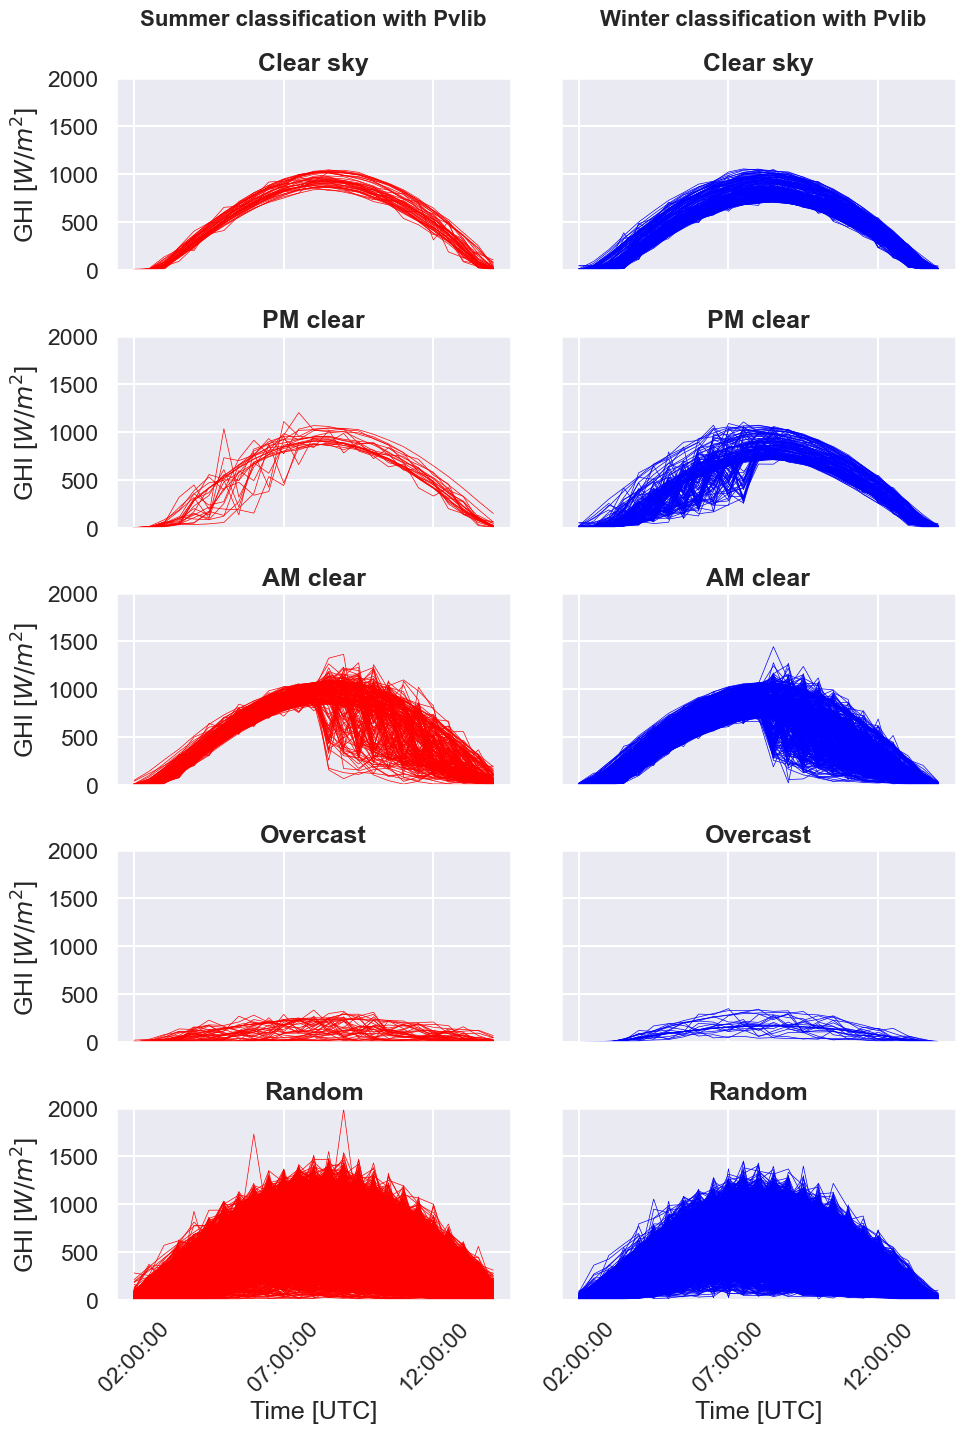

In [144]:
df_raw = new_ios_data_moufia
cloud_cover = 70  # 70% cloud cover
offset = 10  # optional offset value
data_geo = pd.read_csv('data_geo_adaptation.csv', sep=';', index_col=0)
name_station = 'urmoufia'
name_data = 'IOS'
var = 'ghi'

delta_trend = 50
# Linear conversion function
def cloud_cover_to_ghi_linear(cloud_cover, ghi_clear, offset):
    return ghi_clear * (1 - cloud_cover / 100) + offset


def classification_pvlib(df_raw, cloud_cover, offset, data_geo, name_station,name_data,var ,delta_trend):
    ############################################################################# prepare data #############
    df_urmoufia_30min = instantaneous_ios_data(df_raw)
    df_urmoufia_30min_summer = df_urmoufia_30min[df_urmoufia_30min.index.month.isin([11, 12, 1, 2,3,4])]
    df_urmoufia_30min_winter = df_urmoufia_30min[df_urmoufia_30min.index.month.isin([5, 6, 7, 8,9,10])]
    #######################################################################################################
    
    ############################################################################# model PVLIB #############
    info_geo = data_geo.loc[name_station]
    times = df_urmoufia_30min.index.tz_localize('UTC')
    lat = info_geo.Latitude_modif
    long = info_geo.Longitude_modif
    altit = info_geo.Altitude
    loc = location.Location(latitude =lat , longitude = long,  tz=times.tz, altitude = altit)
    sp = loc.get_solarposition(times,temperature=25) #with 25°C same mean température à La Réunion
    # Calculate relative airmass
    r_a = pvlib.atmosphere.get_relative_airmass(sp['zenith']) #relative airmass
    # Convert relative airmass to absolute airmass
    a_a = pvlib.atmosphere.get_absolute_airmass(r_a) #airmass_absolute
    # Example Linke turbidity values (could be obtained from a dataset)
    linke_turbidity = pvlib.clearsky.lookup_linke_turbidity(times, loc.latitude, loc.longitude)
    cs = pvlib.clearsky.ineichen(sp['apparent_zenith'], a_a, linke_turbidity, altitude=loc.altitude)
    # Apply the function to clear-sky GHI to get the overcast GHI
    ghi_overcast = cloud_cover_to_ghi_linear(cloud_cover, cs['ghi'], offset)
    cs['ghi_overcast'] = ghi_overcast.tolist()
    df_cs_ghi = cs[['ghi']]
    df_overcast_ghi = cs[['ghi_overcast']]
    #######################################################################################################

    ############################################################################# 2 saisons #############
    df_summer = df_cs_ghi[df_cs_ghi.index.month.isin([11, 12, 1, 2,3,4])]
    df_winter = df_cs_ghi[df_cs_ghi.index.month.isin([5, 6, 7, 8,9,10])]
    formalis_summer_data = formalisation_data(df_summer,'ghi')
    formalis_winter_data = formalisation_data(df_winter,'ghi')

    #----- summer
    trend_max_summer = formalis_summer_data.max(axis=1).tolist()
    trend_max_summer = [x + delta_trend for x in trend_max_summer]
    trend_min_summer = formalis_summer_data.min(axis=1).tolist()
    trend_min_summer = [x - delta_trend for x in trend_min_summer]
    #----- winter
    trend_max_winter = formalis_winter_data.max(axis=1).tolist()
    trend_max_winter = [x + delta_trend for x in trend_max_winter]
    trend_min_winter = formalis_winter_data.min(axis=1).tolist()
    trend_min_winter = [x - delta_trend for x in trend_min_winter]

    df_summer_overcast = df_overcast_ghi[df_overcast_ghi.index.month.isin([11, 12, 1, 2,3,4])]
    df_winter_overcast = df_overcast_ghi[df_overcast_ghi.index.month.isin([5, 6, 7, 8,9,10])]
    formalis_summer_data_overcast = formalisation_data(df_summer_overcast,'ghi_overcast')
    formalis_winter_data_overcast= formalisation_data(df_winter_overcast,'ghi_overcast')
    #----- summer
    trend_overcast_max_summer = formalis_summer_data_overcast.max(axis=1).tolist()
    trend_overcast_max_summer = [x + delta_trend for x in trend_overcast_max_summer]
    trend_overcast_min_summer = formalis_summer_data_overcast.min(axis=1).tolist()
    trend_overcast_min_summer = [x - delta_trend for x in trend_overcast_min_summer]
    #----- winter
    trend_overcast_max_winter = formalis_winter_data_overcast.max(axis=1).tolist()
    trend_overcast_max_winter = [x + delta_trend for x in trend_overcast_max_winter]
    trend_overcast_min_winter = formalis_winter_data_overcast.min(axis=1).tolist()
    trend_overcast_min_winter = [x - delta_trend for x in trend_overcast_min_winter]
    #######################################################################################################
    
    df_saisons = [df_urmoufia_30min_summer,df_urmoufia_30min_winter]
    list_trend_min = [trend_min_summer,trend_min_winter]
    list_trend_max = [trend_max_summer,trend_max_winter]
    list_overcast_trend_min = [trend_overcast_min_summer,trend_overcast_min_winter]
    list_overcast_trend_max = [trend_overcast_max_summer,trend_overcast_max_winter]
    subtitles = ["Summer classification with Pvlib","Winter classification with Pvlib"]
    list_color = ["red","blue"]
    list_saison = []

    fig, axs = plt.subplots(5, 2, figsize=(10, 15), sharex=True,sharey=True)
    for j in range(len(df_saisons)):
        ################################################################################# Summer ########
        List_dataframe=[]
        
        data,variable, trend_min,trend_max = df_saisons[j],var,list_trend_min[j],list_trend_max[j]
        df = data.copy()
        df_filter = Savitzky_Golay_filter(df, variable, 5 , 2)
        print(df_filter.columns)
        df_summer_form = formalisation_data(df_filter,variable)
        mydf = df_summer_form.dropna(axis=1, how='any')
        nb_tot_day = mydf.shape[1]
        print('Nombre de journée valide à l''analyse :',nb_tot_day)
        
        # Clear sky __________________________________________________________________________________
        selected_columns_day = []
        # Parcourir les colonnes de votre DataFrame
        for col in mydf.columns:
            ghi_values = mydf[col].values
            # Vérifier si toutes les valeurs de ghi_values sont entre les tendances max et min
            if np.all((ghi_values >= trend_min) & (ghi_values <= trend_max)):
                selected_columns_day.append(col)
        df_sun_days = mydf.loc[:, selected_columns_day]
        nb_sun_day = len(selected_columns_day)
        print('Nombre de journée de ciel clair :',nb_sun_day)
        List_dataframe.append(df_sun_days)
        
        # Clear PM __________________________________________________________________________________
        df_clear_PM = mydf.drop(columns=selected_columns_day)
        selected_columns_day = []
        for col in df_clear_PM.columns:
            ghi_values = df_clear_PM[col].values[12:] # compare only PM value
            # Vérifier si toutes les valeurs de ghi_values sont entre les tendances max et min
            if np.all((ghi_values >= trend_min[12:]) & (ghi_values <= trend_max[12:])):
                selected_columns_day.append(col)
        df_select_clear_PM = df_clear_PM.loc[:, selected_columns_day]
        nb_select_clear_PM = len(selected_columns_day)
        print('Nombre de journée de ciel clair PM:',nb_select_clear_PM)
        List_dataframe.append(df_select_clear_PM)
    
        # Clear AM __________________________________________________________________________________
        df_clear_AM = df_clear_PM.drop(columns=selected_columns_day)
        selected_columns_day = []
        for col in df_clear_AM.columns:
            ghi_values = df_clear_AM[col].values[:13]# compare only AM value
            # Vérifier si toutes les valeurs de ghi_values sont entre les tendances max et min
            if np.all((ghi_values >= trend_min[:13]) & (ghi_values <= trend_max[:13])):
                selected_columns_day.append(col)
        df_select_clear_AM = df_clear_AM.loc[:, selected_columns_day]
        nb_select_clear_AM = len(selected_columns_day)
        print('Nombre de journée de ciel clair AM :',nb_select_clear_AM)
        List_dataframe.append(df_select_clear_AM)
        
        # Overcast __________________________________________________________________________________
        trend_min,trend_max = list_overcast_trend_min[j],list_overcast_trend_max[j]
    
        df_overcast = df_clear_AM.drop(columns=selected_columns_day)
        selected_columns_day = []
        # Parcourir les colonnes de votre DataFrame
        for col in df_overcast.columns:
            ghi_values = df_overcast[col].values
            # Vérifier si toutes les valeurs de ghi_values sont entre les tendances max et min
            if np.all((ghi_values <= trend_max)):
                selected_columns_day.append(col)
        df_select_overcast = df_overcast.loc[:, selected_columns_day]
        nb_select_overcast = len(selected_columns_day)
        print('Nombre de journée de ciel couvert :',nb_select_overcast)
        List_dataframe.append(df_select_overcast)
    
        # Random __________________________________________________________________________________
        df_random = df_overcast.drop(columns=selected_columns_day)
        nb_random = df_random.shape[1]
        print('Nombre de journée de ciel random :',nb_random)
        List_dataframe.append(df_random)
        list_saison.append(List_dataframe)
    
    titles =  ['Clear sky','PM clear','AM clear','Overcast','Random']

    data_summer = list_saison[0]
    data_winter = list_saison[1]

    # Ajouter un sous-titre pour chaque colonne de subplots
    fig.text(0.33, 0.95, 'Summer classification with Pvlib', ha='center', fontsize=16, fontweight='bold')
    fig.text(0.78, 0.95, 'Winter classification with Pvlib', ha='center', fontsize=16, fontweight='bold')

    # Loop through each dataframe and plot on the corresponding subplot
    for i, (df1,df2) in enumerate(zip(data_summer, data_winter)):
        df1.plot(ax=axs[i][0], color=list_color[0], legend=False,lw =0.5)
        axs[i][0].set_title(titles[i], fontweight='bold')
        axs[i][0].tick_params(axis='x', rotation=45)
        axs[i][0].set_xlabel('Time [UTC]')
        axs[i][0].set_ylabel('GHI [$W/m^2$]')
        axs[i][0].set_ylim(0,2000)
        #axs[i][0].grid(True, which='both', linewidth=1)

        df2.plot(ax=axs[i][1], color=list_color[1], legend=False,lw =0.5)
        axs[i][1].set_title(titles[i], fontweight='bold')
        axs[i][1].tick_params(axis='x', rotation=45)
        axs[i][1].set_xlabel('Time [UTC]')
        axs[i][0].set_ylim(0,2000)


    
    # Adjust layout to prevent overlap
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    #plt.savefig(f'data_urmoufia/img/day_classification_{name_data}_{name_station}.png',dpi=600, bbox_inches='tight', pad_inches=0.05)
    # Show the plot
    plt.show()
    
    

    return list_saison



list_saison = classification_pvlib(df_raw, cloud_cover, offset, data_geo, name_station,name_data,var,delta_trend)

In [94]:
list_saison

[[ID_date      98       477      834       1183     1200     1574     1934  \
  heure                                                                      
  02:00:00    2.985    2.411    2.298     3.029    0.000    0.000    1.566   
  02:30:00    6.888    7.230    8.850    19.300    3.133    5.559    5.145   
  03:00:00   85.100   45.590   64.240   139.600   44.700   62.590   28.640   
  03:30:00  197.100  174.600  188.400   216.500  176.100  177.400  173.600   
  04:00:00  319.800  306.000  328.800   357.900  322.900  291.700  361.300   
  04:30:00  429.600  424.400  467.400   489.200  477.400  415.400  433.400   
  05:00:00  548.600  539.500  580.200   601.800  588.000  516.800  546.300   
  05:30:00  650.300  646.500  685.700   704.000  694.300  609.500  645.900   
  06:00:00  751.000  743.000  776.000   787.300  777.900  701.700  731.700   
  06:30:00  820.000  805.000  851.000   859.000  872.000  775.100  809.000   
  07:00:00  876.000  884.000  868.000   898.000  901.000  828.00

Liste des jours pour chaque classe : [[41, 21, 199, 39, 2073], [214, 154, 510, 21, 1695]]
Liste des fréquence pour chaque classe : [[1.73, 0.88, 8.39, 1.64, 87.36], [8.25, 5.94, 19.66, 0.81, 65.34]]


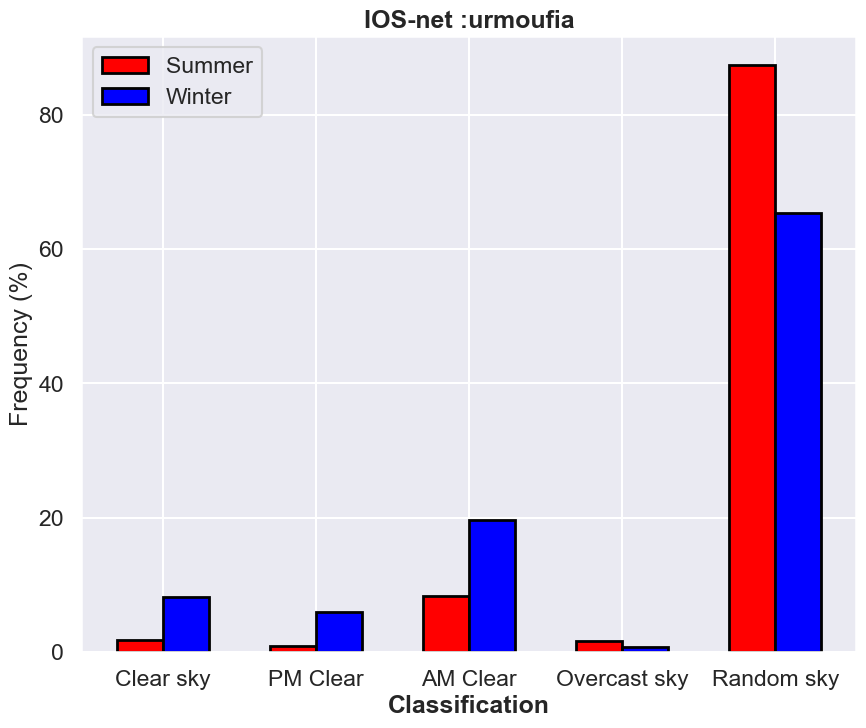

In [145]:
days_tot = [2373,2594]

list_nb_day_ios = [[ df.shape[1] for df in list_saison[i] ] for i in range(2)]
print('Liste des jours pour chaque classe :',list_nb_day_ios)

freq_ios = [[round(i/days_tot[j]*100,2) for i in list_nb_day_ios[j] ] for j in range(2)]
print('Liste des fréquence pour chaque classe :',freq_ios)

list_IOS_net_summer = freq_ios[0]
list_IOS_net_winter = freq_ios[1]

list_class = ['Clear sky','PM Clear','AM Clear','Overcast sky','Random sky']
name_station = 'urmoufia'
name_data = 'IOS'
name_data_title = 'IOS-net'

def compare_freq(list_IOS_net_summer, list_IOS_net_winter, list_class, name_station,name_data,name_data_title):
    plt.figure(figsize=(10, 8))
    
    # Bar positions
    bar_width = 0.3
    bar1 = range(len(list_class))
    bar2 = [i + bar_width for i in bar1]

    # Plot bars
    plt.bar(bar1, list_IOS_net_summer, width=bar_width, color='red', edgecolor='black', linewidth=2, label='Summer')
    plt.bar(bar2, list_IOS_net_winter, width=bar_width, color='blue', edgecolor='black', linewidth=2, label='Winter')
    
    # Labels and title
    plt.xlabel('Classification', fontweight='bold')
    plt.ylabel('Frequency (%)')
    plt.xticks([r + bar_width/2 for r in range(len(list_class))], list_class)
    plt.title(f'{name_data_title} :{name_station}', fontweight='bold')
    plt.legend(loc='best')

    plt.savefig(f'data_urmoufia/img/{name_data}_classification_PVlib_freq_bar_of_{name_station}.png',dpi=600, bbox_inches='tight', pad_inches=0.05)
    
    # Show plot
    plt.show()

    return 

compare_freq(list_IOS_net_summer, list_IOS_net_winter, list_class, name_station,name_data,name_data_title)

# SARAH-3 classification

Le nombre de valeurs NaN avant la sélection : 425
Le nombre de valeurs NaN après la sélection : 425
Index(['SIS_SARAH_3', 'SIS_SARAH_3_smoothed'], dtype='object')
Nombre de journée valide à lanalyse : 2553
Nombre de journée de ciel clair : 139
Nombre de journée de ciel clair PM: 181
Nombre de journée de ciel clair AM : 353
Nombre de journée de ciel couvert : 21
Nombre de journée de ciel random : 1859
Le nombre de valeurs NaN avant la sélection : 301
Le nombre de valeurs NaN après la sélection : 301
Index(['SIS_SARAH_3', 'SIS_SARAH_3_smoothed'], dtype='object')
Nombre de journée valide à lanalyse : 2616
Nombre de journée de ciel clair : 358
Nombre de journée de ciel clair PM: 234
Nombre de journée de ciel clair AM : 460
Nombre de journée de ciel couvert : 23
Nombre de journée de ciel random : 1541


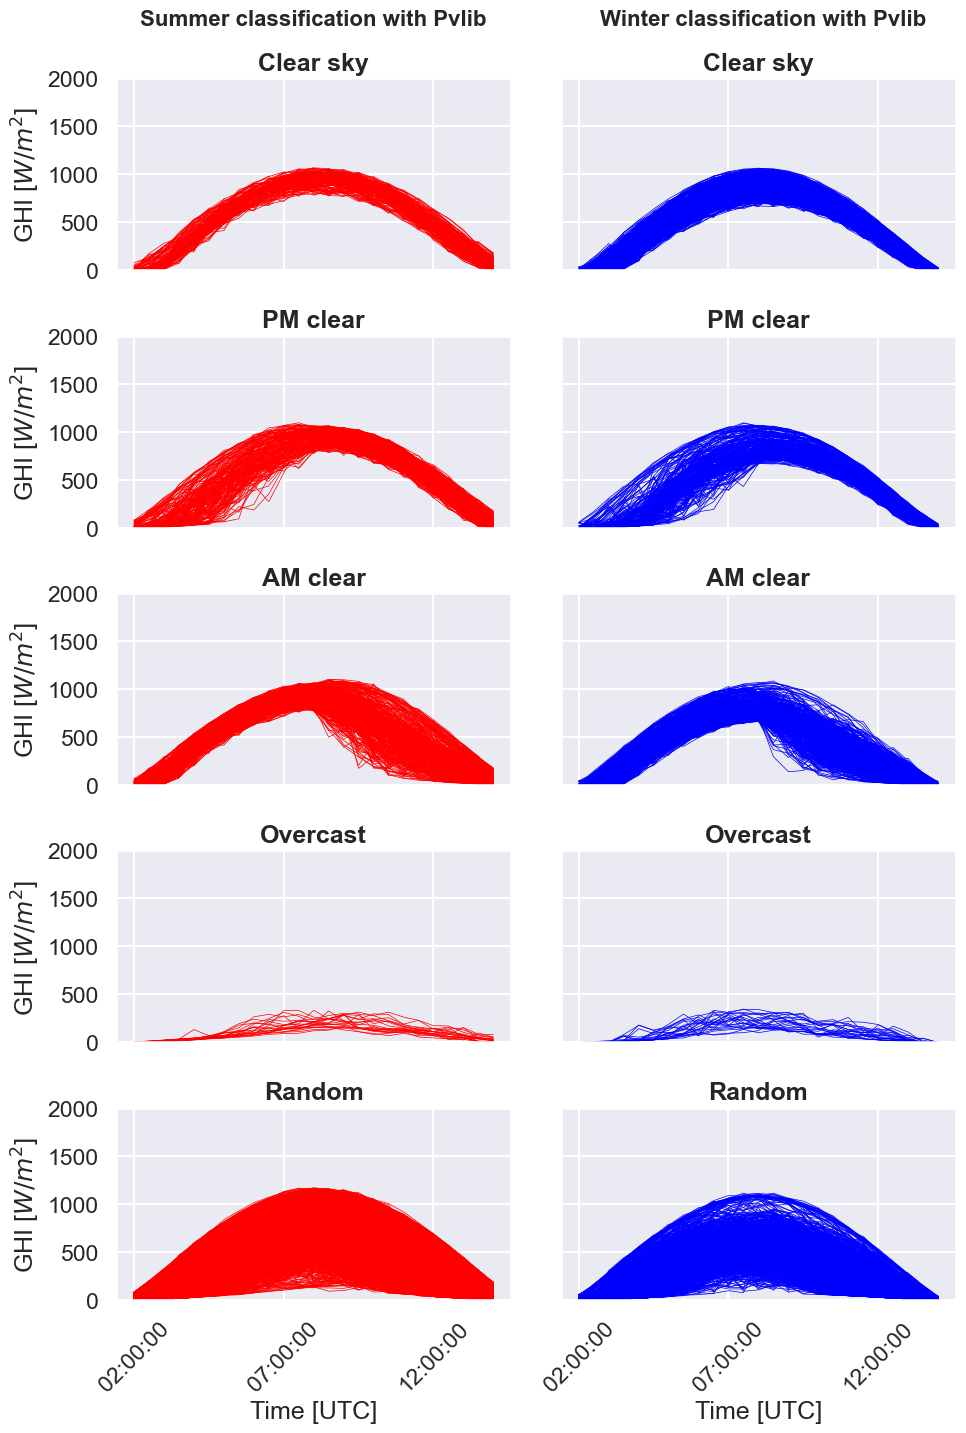

In [146]:
df_raw = instantaneous_ios_data(new_sarah_data_moufia)
cloud_cover = 70  # 70% cloud cover
offset = 10  # optional offset value
data_geo = pd.read_csv('data_geo_adaptation.csv', sep=';', index_col=0)
name_station = 'urmoufia'
name_data = 'SARAH'
var = 'SIS_SARAH_3'
delta_trend = 50

list_saison_sarah = classification_pvlib(df_raw, cloud_cover, offset, data_geo, name_station,name_data,var,delta_trend)

Liste des jours pour chaque classe : [[139, 181, 353, 21, 1859], [358, 234, 460, 23, 1541]]
Liste des fréquence pour chaque classe : [[5.44, 7.09, 13.83, 0.82, 72.82], [13.69, 8.94, 17.58, 0.88, 58.91]]


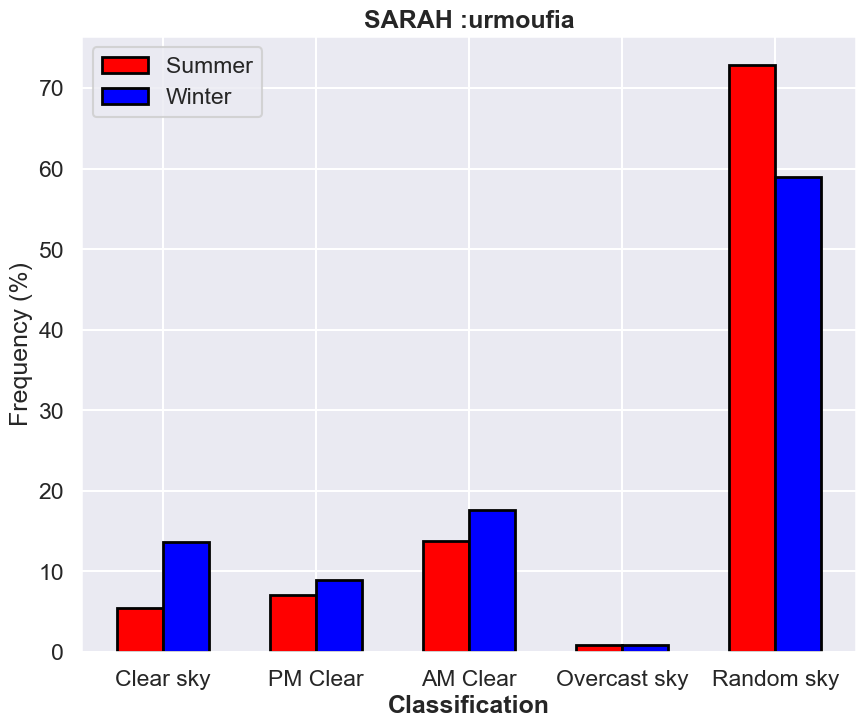

In [147]:
days_tot = [2553,2616]

list_nb_day_sarah = [[ df.shape[1] for df in list_saison_sarah[i] ] for i in range(2)]
print('Liste des jours pour chaque classe :',list_nb_day_sarah)

freq_sarah = [[round(i/days_tot[j]*100,2) for i in list_nb_day_sarah[j] ] for j in range(2)]
print('Liste des fréquence pour chaque classe :',freq_sarah)

list_IOS_net_summer = freq_sarah[0]
list_IOS_net_winter = freq_sarah[1]
list_class = ['Clear sky','PM Clear','AM Clear','Overcast sky','Random sky']
name_station = 'urmoufia'
name_data = 'SARAH'
name_data_title = name_data

compare_freq(list_IOS_net_summer, list_IOS_net_winter, list_class, name_station,name_data,name_data_title)

In [149]:
list_saison_sarah[0][1]

ID_date,15,51,77,80,85,96,110,113,336,350,...,5090,5122,5132,5145,5178,5190,5193,5251,5254,5255
heure,,,,,,,,,,,,,,,,,,,,,
02:00:00,6.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,5.000,18.000,...,67.000,7.000,6.002,4.001,0.000,0.000,0.000,0.000,0.000,0.000
02:30:00,16.000,9.000,4.000,45.999,3.000,2.000,1.000,1.000,15.000,181.000,...,25.001,16.000,15.000,114.998,6.000,5.000,4.000,0.000,0.000,0.000
03:00:00,26.000,26.000,14.000,31.000,91.998,11.001,10.000,10.000,26.000,231.995,...,237.995,27.000,26.000,279.993,17.000,15.000,14.000,48.000,7.000,9.000
03:30:00,37.000,31.001,25.000,25.000,222.998,47.001,29.003,21.000,82.001,362.002,...,221.998,259.995,37.000,71.003,222.000,182.997,25.000,148.995,184.996,74.001
04:00:00,63.001,260.001,37.000,392.997,387.999,352.998,246.998,42.003,163.000,371.004,...,431.994,453.998,96.002,481.987,385.997,354.997,37.000,123.001,27.000,39.005
04:30:00,116.004,449.001,104.999,510.997,452.994,480.998,380.999,201.000,341.002,505.002,...,492.996,542.992,483.999,574.001,235.998,126.004,243.004,95.000,185.997,58.001
05:00:00,645.997,487.002,292.999,637.999,254.010,606.999,453.998,256.004,494.001,596.005,...,768.998,672.994,631.999,659.000,455.996,200.002,565.000,127.000,446.996,268.999
05:30:00,808.997,518.002,509.996,744.999,749.999,717.999,605.994,366.005,685.999,795.002,...,876.997,759.996,821.998,780.999,699.996,504.005,782.997,403.001,382.000,556.999
06:00:00,927.997,631.004,646.000,848.998,828.000,817.000,477.005,655.000,754.999,969.999,...,894.998,836.993,890.998,852.000,775.996,791.999,863.998,702.999,602.999,688.999


In [150]:
list_saison[0][1]

ID_date,129,447,449,474,832,835,843,1192,1210,1211,...,1890,1911,1937,1953,3378,3767,3774,4868,5232,5235
heure,,,,,,,,,,,,,,,,,,,,,
02:00:00,2.206,1.952,2.067,1.608,1.494,1.609,2.413,0.200,0.00,0.000,...,0.00,1.342,1.342,1.342,0.821,0.831,0.781,0.769,0.805,0.811
02:30:00,5.629,10.220,12.400,6.087,10.230,5.630,7.580,7.133,1.20,1.367,...,13.53,6.933,3.802,2.684,0.816,3.577,0.791,0.834,3.366,1.829
03:00:00,14.360,38.590,82.000,50.530,28.840,49.640,44.230,45.370,21.63,18.020,...,40.58,58.150,51.670,20.360,59.640,32.940,7.475,13.120,24.720,57.480
03:30:00,36.190,81.500,182.100,91.200,102.600,176.000,97.800,114.200,34.47,37.420,...,316.70,210.000,61.720,51.450,59.130,44.330,31.970,42.490,37.570,30.400
04:00:00,52.660,294.800,385.800,199.500,354.900,314.400,148.400,91.200,280.90,284.800,...,445.20,352.700,302.400,146.500,132.400,226.100,32.950,48.050,104.500,167.900
04:30:00,161.100,364.600,528.400,133.300,235.800,102.600,97.900,83.500,553.70,414.100,...,193.80,468.300,414.600,84.100,214.800,335.100,40.230,163.400,170.800,416.800
05:00:00,411.400,554.600,393.300,1031.000,271.800,729.000,543.100,252.500,508.40,524.900,...,388.80,493.700,540.800,121.000,194.200,605.200,54.910,477.200,128.100,500.500
05:30:00,473.000,493.800,573.400,319.200,655.100,698.900,656.100,594.900,628.10,626.600,...,716.80,133.500,646.500,544.600,186.700,216.100,205.700,575.000,270.000,493.100
06:00:00,338.500,818.000,758.000,630.900,743.000,758.000,780.000,490.100,750.20,713.200,...,911.00,798.100,759.100,660.400,152.000,674.500,356.200,665.200,678.400,684.900


In [151]:
# Méthode 1 : Utilisation des ensembles
def method_set(liste1,liste2):
    return list(set(liste1) & set(liste2))


same_class = method_set(list_saison[0][1].columns,list_saison_sarah[0][1].columns)

In [152]:
same_class

[1953, 835, 1211]

In [153]:
#------- GOOD DATA ------------------------------------------------------------------------
data_ios_good = list_saison[0][1].loc[:, same_class]
data_sarah_good = list_saison_sarah[0][1].loc[:, same_class]
#------------------------------------------------------------------------------------------

In [154]:
data_ios_good

ID_date,1953,835,1211
heure,,,
02:00:00,1.342,1.609,0.000
02:30:00,2.684,5.630,1.367
03:00:00,20.360,49.640,18.020
03:30:00,51.450,176.000,37.420
04:00:00,146.500,314.400,284.800
04:30:00,84.100,102.600,414.100
05:00:00,121.000,729.000,524.900
05:30:00,544.600,698.900,626.600
06:00:00,660.400,758.000,713.200


In [155]:
data_sarah_good

ID_date,1953,835,1211
heure,,,
02:00:00,0.000,0.000,0.000
02:30:00,0.000,1.000,1.000
03:00:00,22.001,11.000,9.000
03:30:00,26.002,104.996,20.000
04:00:00,150.004,362.998,31.000
04:30:00,439.999,471.999,58.001
05:00:00,580.998,266.001,214.000
05:30:00,684.999,630.000,411.996
06:00:00,780.000,733.995,627.998


index min :  2008-12-01 00:00:00
index max :  2023-10-13 23:59:00
Le nombre de valeurs NaN avant la sélection : 6528
Le nombre de valeurs NaN après la sélection : 6528
Index(['ghi', 'ghi_smoothed'], dtype='object')
Nombre de journée valide à lanalyse : 2373
Nombre de journée de ciel clair : 41
Nombre de journée de ciel clair PM: 21
Nombre de journée de ciel clair AM : 199
Nombre de journée de ciel couvert : 39
Nombre de journée de ciel random : 2073
Le nombre de valeurs NaN avant la sélection : 2430
Le nombre de valeurs NaN après la sélection : 2430
Index(['ghi', 'ghi_smoothed'], dtype='object')
Nombre de journée valide à lanalyse : 2594
Nombre de journée de ciel clair : 214
Nombre de journée de ciel clair PM: 154
Nombre de journée de ciel clair AM : 510
Nombre de journée de ciel couvert : 21
Nombre de journée de ciel random : 1695


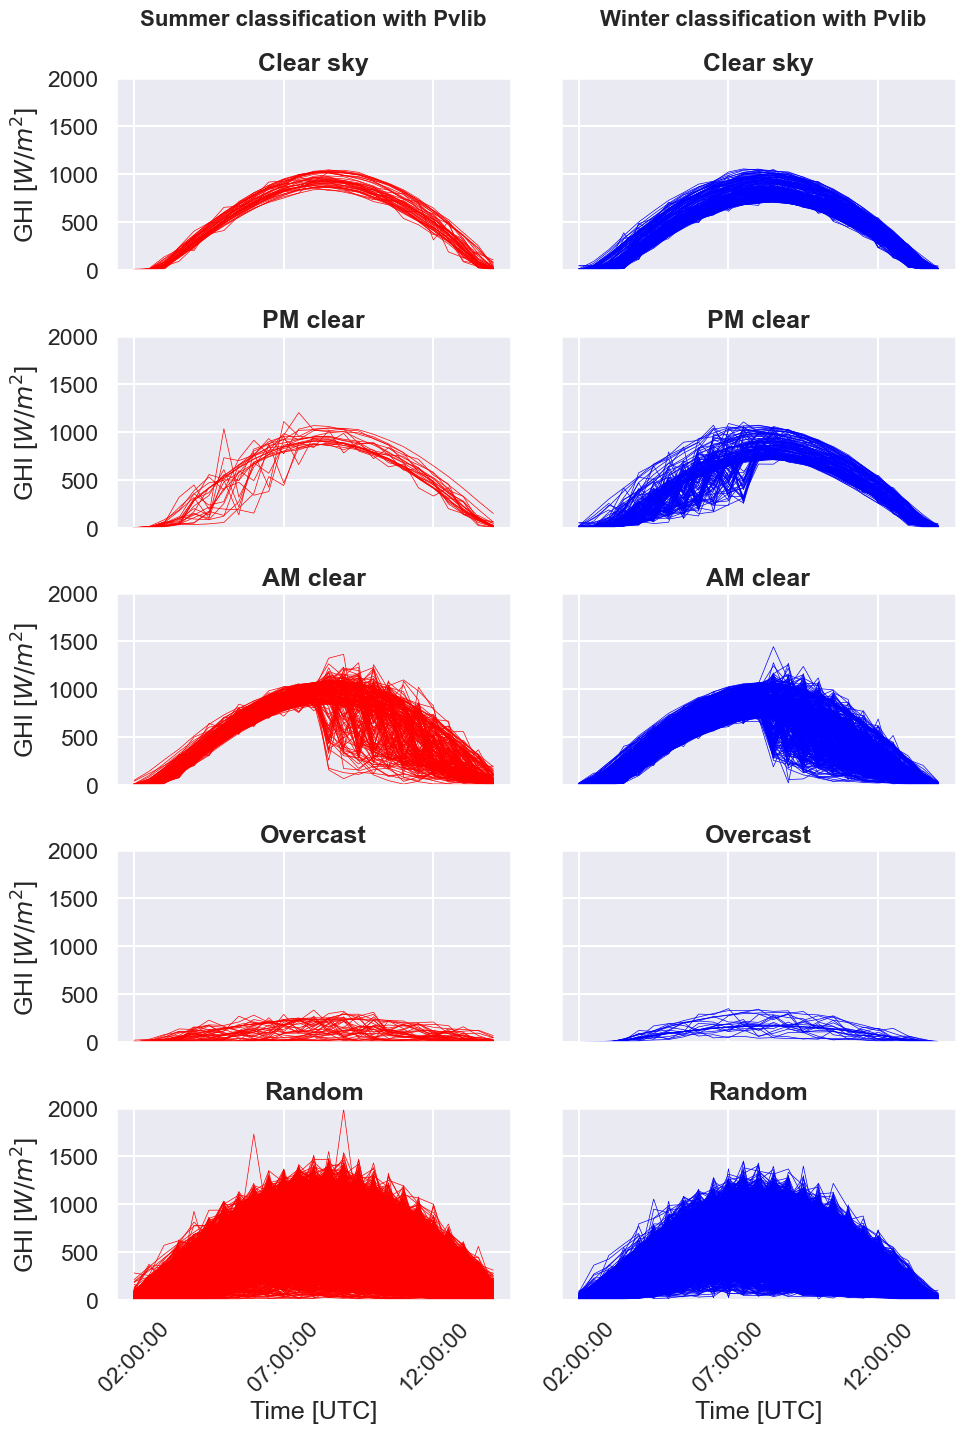

Le nombre de valeurs NaN avant la sélection : 425
Le nombre de valeurs NaN après la sélection : 425
Index(['SIS_SARAH_3', 'SIS_SARAH_3_smoothed'], dtype='object')
Nombre de journée valide à lanalyse : 2553
Nombre de journée de ciel clair : 139
Nombre de journée de ciel clair PM: 181
Nombre de journée de ciel clair AM : 353
Nombre de journée de ciel couvert : 21
Nombre de journée de ciel random : 1859
Le nombre de valeurs NaN avant la sélection : 301
Le nombre de valeurs NaN après la sélection : 301
Index(['SIS_SARAH_3', 'SIS_SARAH_3_smoothed'], dtype='object')
Nombre de journée valide à lanalyse : 2616
Nombre de journée de ciel clair : 358
Nombre de journée de ciel clair PM: 234
Nombre de journée de ciel clair AM : 460
Nombre de journée de ciel couvert : 23
Nombre de journée de ciel random : 1541


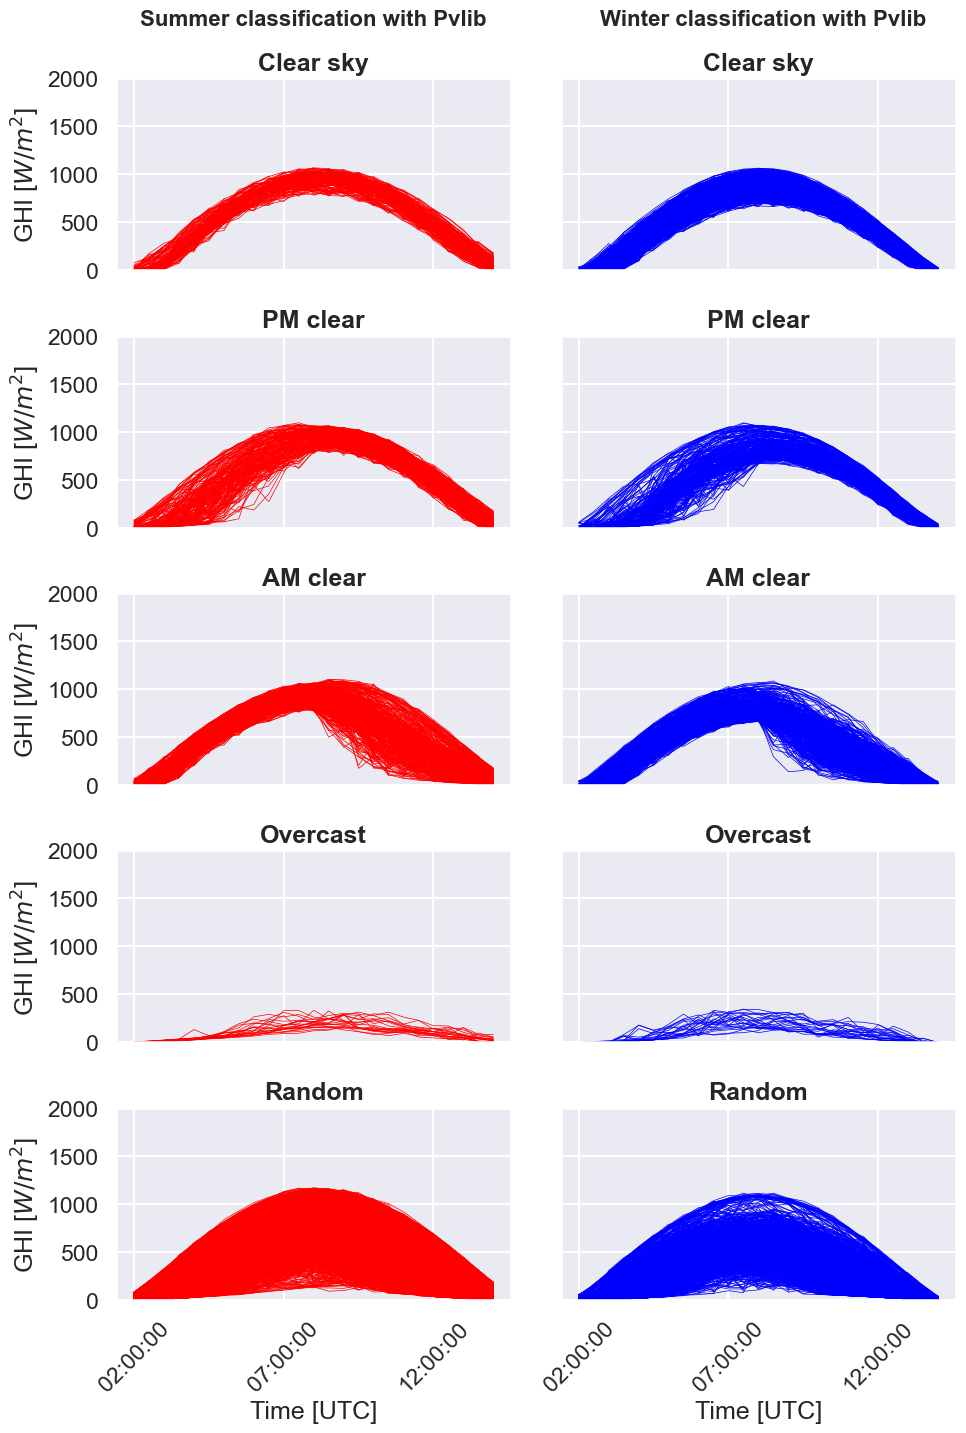

[1953, 835, 1211]

In [160]:
df_ios_net_raw = pd.read_csv('data_urmoufia/data_UTC/urmoufia.csv', sep=';', index_col=0)
df_sarah_raw = pd.read_csv('data_urmoufia/data_UTC/SARAH_3_SIS_moufia.csv', sep=';', index_col=0)
cloud_cover = 70  # 70% cloud cover
offset = 10  # optional offset value
data_geo = pd.read_csv('data_geo_adaptation.csv', sep=';', index_col=0)
name_station = 'urmoufia'
var_ios = 'ghi'
var_sarah = 'SIS_SARAH_3'
delta_trend = 50

def compare_presicion_same_ID_class(df_ios_net_raw,df_sarah_raw,cloud_cover,offset,data_geo,name_station,var_ios,var_sarah,delta_trend):
    new_ios_data_moufia , new_sarah_data_moufia = selection_same_temporal_data(df_ios_net_raw,df_sarah_raw)
    df_raw_ios = instantaneous_ios_data(new_ios_data_moufia)
    df_raw_sarah = instantaneous_ios_data(new_sarah_data_moufia)
    list_saison_ios = classification_pvlib(df_raw_ios, cloud_cover, offset, data_geo, name_station,'IOS-net',var_ios,delta_trend)
    list_saison_sarah = classification_pvlib(df_raw_sarah, cloud_cover, offset, data_geo, name_station,'SARAH-3',var_sarah,delta_trend)
    index_clear_sky_summer = method_set(list_saison_ios[0][1].columns,list_saison_sarah[0][1].columns)

    return index_clear_sky_summer

compare_presicion_same_ID_class(df_ios_net_raw,df_sarah_raw,cloud_cover,offset,data_geo,name_station,var_ios,var_sarah,delta_trend)